In [1]:
#%reload_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

import cv2
import numpy as np
import SimpleITK as sitk
import pandas as pd
import pandas.tools.plotting as pdplot

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
import time
import re
import sys
import pprint

import scipy.signal
import scipy.misc
import scipy.ndimage.filters

import PIL
from PIL import ImageDraw

import statsmodels.api as sm

import sklearn.decomposition

import skimage.filters
import skimage.util

import angles

from ipywidgets import interact, interactive, fixed
#from IPython.html import widgets
import ipywidgets as widgets
from IPython.display import clear_output, display, HTML
from detect_peaks import detect_peaks

sys.path.insert(0, 'pyLAR')
sys.path.insert(0, 'PyRPCA')

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 30, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

titlesize = 20
labelsize = 15
linewidth = 4

## Utility Functions

In [2]:
def cvShowImage(imDisp, strName, strAnnotation = '', textColor=(0,0,255), resizeAmount=None):

    if resizeAmount is not None:
        imDisp = cv2.resize(imDisp.copy(), None, fx=resizeAmount, fy=resizeAmount)

    imDisp = cv2.cvtColor(imDisp, cv2.COLOR_GRAY2RGB)
    
    if len(strAnnotation) > 0:
        cv2.putText(imDisp, strAnnotation, (10, 20), cv2.FONT_HERSHEY_PLAIN, 2.0, textColor, thickness=2)
        
    cv2.imshow(strName, imDisp)   
    
def cvShowColorImage(imDisp, strName, strAnnotation = '', textColor=(0,0,255), resizeAmount=None):
    
    if resizeAmount is not None:
        imDisp = cv2.resize(imDisp.copy(), None, fx=resizeAmount, fy=resizeAmount)
    
    if len(strAnnotation) > 0:
        cv2.putText(imDisp, strAnnotation, (10, 20), cv2.FONT_HERSHEY_PLAIN, 2.0, textColor, thickness=2)
        
    cv2.imshow(strName, imDisp)   
    
def mplotShowImage(imInput):
    plt.imshow(imInput, cmap=plt.cm.gray)
    plt.grid(False)
    plt.xticks(())
    plt.yticks(())
    
def normalizeArray(a):
    return np.single(0.0 + a - a.min()) / (a.max() - a.min())   

def AddTextOnImage(imInput, strText, loc=(2,2) ):
    
    imInputPIL = PIL.Image.fromarray( imInput )
    d = ImageDraw.Draw( imInputPIL )
    d.text( loc, strText )
    return np.asarray( imInputPIL )

def AddTextOnVideo( imVideo, strText, loc=(2,2) ):

    imVideoOut = np.zeros_like( imVideo )
    
    for i in range(imVideo.shape[2]):
        imVideoOut[:, :, i] = AddTextOnImage( imVideo[:,:,i], strText, loc )
        
    return imVideoOut
    
def cvShowVideo(imVideo, strWindowName, waitTime=30, resizeAmount=None):
    
    if not isinstance(imVideo, list):
        imVideo = [imVideo]
        strWindowName = [strWindowName]
        
    # find max number of frames
    maxFrames = 0
    
    for vid in range(len(imVideo)):
        
        if imVideo[vid].shape[2] > maxFrames:
            maxFrames = imVideo[vid].shape[2]
    
    # display video
    blnLoop = True      
    fid = 0
    
    while True:
        
        for vid in range(len(imVideo)):

            curVideoFid = fid % imVideo[vid].shape[2]
            imCur = imVideo[vid][:,:,curVideoFid]

            # resize image if requested
            if resizeAmount:
                imCur = scipy.misc.imresize(imCur, resizeAmount)

            # show image
            cvShowImage(imCur, strWindowName[vid], '%d' % (curVideoFid+1))

        # look for "esc" key
        k = cv2.waitKey(waitTime) & 0xff

        if blnLoop:

            if k == 27:            
                break
            elif k == ord(' '):
                blnLoop = False
            else:
                fid = (fid + 1) % maxFrames
                
        else:
                    
            if k == 27: # escape           
                
                break
                
            elif k == ord(' '): # space
                
                blnLoop = True
                
            elif k == 81: # left arrow
                
                fid = (fid - 1) % maxFrames
                
            elif k == 83: # right arrow
                
                fid = (fid + 1) % maxFrames                
            
    for vid in range(len(imVideo)):            
        cv2.destroyWindow(strWindowName[vid])
    
def normalizeArray(a):
    return (0.0 + a - a.min()) / (a.max() - a.min())    
    
def loadVideoFromFile(dataFilePath, sigmaSmooth=None, resizeAmount=None):
    
    vidseq = cv2.VideoCapture(dataFilePath)

    print vidseq, vidseq.isOpened()
    
    # print metadata
    metadata = {}
    
    numFrames = vidseq.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT)
    print '\tFRAME_COUNT = ', numFrames
    metadata['FRAME_COUNT'] = numFrames
    
    fps = vidseq.get(cv2.cv.CV_CAP_PROP_FPS)
    if fps > 0:
        print '\tFPS = ', fps
        metadata['FPS'] = fps

    fmt = vidseq.get(cv2.cv.CV_CAP_PROP_FORMAT)
    if fmt > 0:
        print '\FORMAT = ', fmt
        metadata['FORMAT'] = fmt
        
    vmode = vidseq.get(cv2.cv.CV_CAP_PROP_MODE)
    if vmode > 0:
        print '\MODE = ', vmode
        metadata['MODE'] = MODE
        
    # smooth if wanted
    if sigmaSmooth:        
        wSmooth = 4 * sigmaSmooth + 1            
    
    print metadata
    
    # read video frames
    imInput = []
    
    fid = 0
    prevPercent = 0
    print '\n'
    
    while True:
        valid_object, frame = vidseq.read()    
        
        if not valid_object:
            break    
             
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        if resizeAmount:
            frame = scipy.misc.imresize(frame, resizeAmount)
        
        if sigmaSmooth:        
            frame = cv2.GaussianBlur(frame, (wSmooth, wSmooth), 0)            
        if np.size(imInput) == 0:
            imInput = frame
        else:
            imInput = np.dstack((imInput, frame))            

        # update progress
        fid += 1
        curPercent = np.floor(100.0*fid/numFrames)
        if curPercent > prevPercent:
            prevPercent = curPercent
            print '%.2d%%' % curPercent, 
            
    print '\n'
    
    vidseq.release()
    
    return (imInput, metadata)

def writeVideoToFile(imVideo, filename, codec='DIVX', fps=30):

    # start timer
    tStart = time.time()

    # write video
    height, width, numFrames = imVideo.shape
    
    fourcc = cv2.cv.FOURCC(*list(codec))    
    writer = cv2.VideoWriter(filename, fourcc, fps=fps, frameSize=(width, height), isColor=0)

    print writer.isOpened()
    for fid in range(numFrames):
        writer.write(imVideo[:,:,fid].astype('uint8'))
        
    # end timer        
    tEnd = time.time()    
    print 'Writing video {} took {} seconds'.format(filename, tEnd - tStart) 
    
    # release
    writer.release()      
    
def writeVideoAsTiffStack(imVideo, strFilePrefix):
    
    # start timer
    tStart = time.time()
    
    for fid in range(imVideo.shape[2]):
        
        plt.imsave(strFilePrefix + '.%.3d.tif' % (fid+1), imVideo[:, :, fid])

    # end timer        
    tEnd = time.time()    
    print 'Writing video {} took {} seconds'.format(strFilePrefix, tEnd - tStart) 
        
def mplotShowMIP(im, axis, xlabel=None, ylabel=None, title=None):

    plt.imshow(im.max(axis))
    
    if title:
        plt.title(title)

    if xlabel:
        plt.xlabel(xlabel)
        
    if ylabel:
        plt.ylabel(ylabel)

def convertFromRFtoBMode( imInputRF ):
    return np.abs(scipy.signal.hilbert(imInputRF, axis=0))

def normalizeAngles(angleList, angle_range):
    return np.array([angles.normalize(i, angle_range[0], angle_range[1]) for i in angleList])

def SaveFigToDisk(saveDir, fileName, saveext = ['.png', '.eps'], **kwargs):
    for ext in saveext:
        plt.savefig( os.path.join(saveDir, fileName + ext), **kwargs)

def SaveImageToDisk(im, saveDir, fileName, saveext = ['.png']):
    for ext in saveext:
        plt.imsave( os.path.join(saveDir, fileName + ext), im )
        
def generateGatedVideoUsingSplineInterp(imInput, numOutFrames, minFrame, maxFrame, splineOrder):
    
    tZoom = np.float(numOutFrames) / (maxFrame - minFrame + 1)

    return scipy.ndimage.interpolation.zoom(imInput[:,:,minFrame:maxFrame+1], (1, 1, tZoom), order=splineOrder) 

def ncorr(imA, imB):
    
    imA = (imA - imA.mean()) / imA.std()
    imB = (imB - imB.mean()) / imB.std()
    
    return np.mean(imA * imB)    

## Set results root directory

In [3]:
#resultsRootDir = '.'
#resultsRootDir = '/home/cdeepakroy/work/gdrive_kitware/LowCostUltrasound/results/videos'
#resultsRootDir = '../../paper/MICCAI_2015/latex/srclnx/figures/'
resultsRootDir = 'results'

## Load Image Data From Disk

##### Set the data root directory here

In [4]:
#dataRootDir = 'data/SHeart-HRes-LFPS/'
#dataRootDir = 'data/SHeart2015-01-21/'
dataRootDir = 'data/SHeart2015-02-20-HRes-HFPS/'
#dataRootDir = 'data/fromMonte/Validation_Study_Export27July2015/'

# List all readable data files
dataFiles = {'prefix': [],
             'ext': [],
             'path': []}

i = 0
for f in os.listdir(dataRootDir):
    
    prefix, ext = os.path.splitext(f)
    
    if ext not in ['.mha', '.avi', '.tif', '.mp4']:        
        continue        
    else:
        print '%d: %s' % (i, f)        
        dataFiles['prefix'].append(prefix)
        dataFiles['ext'].append(ext)
        dataFiles['path'].append( os.path.join(dataRootDir, f) )
        i += 1    

0: Heart_20150220_150858.avi
1: Heart_20150220_151027.avi
2: Heart_20150220_151146.avi
3: Heart_20150220_151322.avi
4: Heart_20150220_151848.avi


##### Select dataset to analyze

In [5]:
xyROI = {}
downsizeAmount = None

# set parameters
if False: # vevo2100 data from Monte
    
    datasetId = 0     
    downsizeAmount = 1
    #xyROI = { 'min_X': 117, 'max_X': 192, 'min_Y': 723, 'max_Y': 540 }
    resizeAmount = 1.0 # for opencv video display only    

if True: # high-res probe High FPS
    
    datasetId = 2     
    downsizeAmount = 0.5
    xyROI = {'min_X': np.round(250 * downsizeAmount),
             'max_X': np.round(1300 * downsizeAmount), 
             'min_Y': np.round(40 * downsizeAmount) }
    #xyROI = { 'min_X': 600, 'max_X': 1000, 'min_Y': 300, 'max_Y': 750 }
    resizeAmount = 1.0 / downsizeAmount # for opencv video display only    

if False: # high-res probe Low FPS
    
    datasetId = 2 
    xyROI = { 'min_X': 150, 'max_X': 850 }
    resizeAmount = 0.75 # for opencv video display

if False: # Low-res probe
    
    datasetId = 7 
    framesPerSec = 10
    resizeAmount = 1.0 # for opencv video display only
    
print 'Selected dataset: ',  dataFiles['path'][datasetId]    

Selected dataset:  data/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151146.avi


##### Load selected dataset

In [6]:
cap = cv2.VideoCapture(dataFiles['path'][datasetId])
print cap.isOpened()
cap.release()

True


In [7]:
# load data
print "\nLoading %s: \n" % (dataFiles['path'][datasetId])

if dataFiles['ext'][datasetId] == '.mha':
    
    imInput_sitk = sitk.ReadImage( dataFiles['path'][datasetId] )
    
    print '\tImage Type: ', imInput_sitk.GetPixelIDTypeAsString()
    
    imInput_highres_uncropped = np.transpose( sitk.GetArrayFromImage( imInput_sitk ), [1, 2, 0] )      
    
    print '\tSpacing: ', np.array(imInput_sitk.GetSpacing())[ix_([1, 2, 0])]
    
elif dataFiles['ext'][datasetId] in [ '.avi', '.tif', '.mp4' ]:    

    imInput_highres_uncropped, metadata = loadVideoFromFile(dataFiles['path'][datasetId], resizeAmount=downsizeAmount)
    
    if dataFiles['ext'][datasetId] == '.avi':
    
        if metadata.has_key('FPS'):
            framesPerSec = metadata['FPS']
            
        pass              
            
        if metadata.has_key('FRAME_COUNT'):                           
            
            if metadata['FRAME_COUNT'] < imInput_highres_uncropped.shape[2]:
                
                numChannels = imInput_highres_uncropped.shape[2] / metadata['FRAME_COUNT']                
                print 'Video seems to be in color with %d channels' % numChannels
                imInput_highres_uncropped = imInput_highres_uncropped[:,:,::numChannels]
        pass
else:    
    raise ValueError('Unknown file type %s' % dataFiles['ext'][datasetId])

print '\tImage Size: ', imInput_highres_uncropped.shape


Loading data/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151146.avi: 

<VideoCapture 0x7f287fb59fd0> True
	FRAME_COUNT =  497.0
	FPS =  35.8333333333
{'FRAME_COUNT': 497.0, 'FPS': 35.833333333333336}


01% 02% 03% 04% 05% 06% 07% 08% 09% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99% 100% 

	Image Size:  (434, 777, 497)


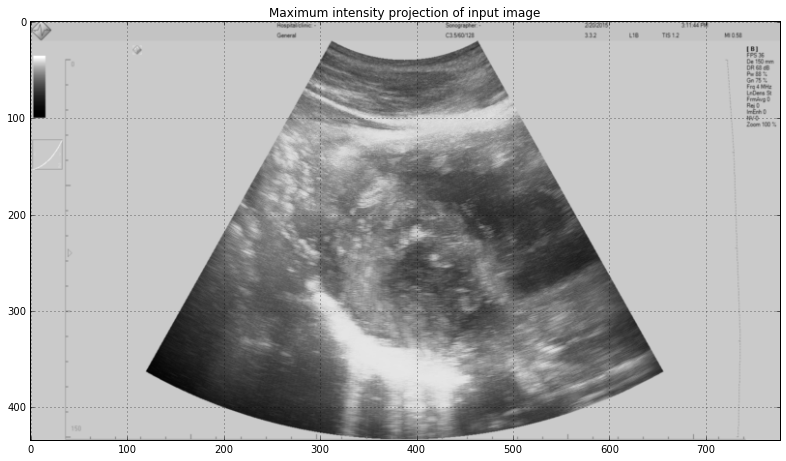

In [8]:
# show mip
plt.figure()
plt.imshow(imInput_highres_uncropped.max(2))
plt.title('Maximum intensity projection of input image')


Image Size After Cropping:  (414, 525, 497)


/home/cdeepakroy/anaconda/envs/lcus/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


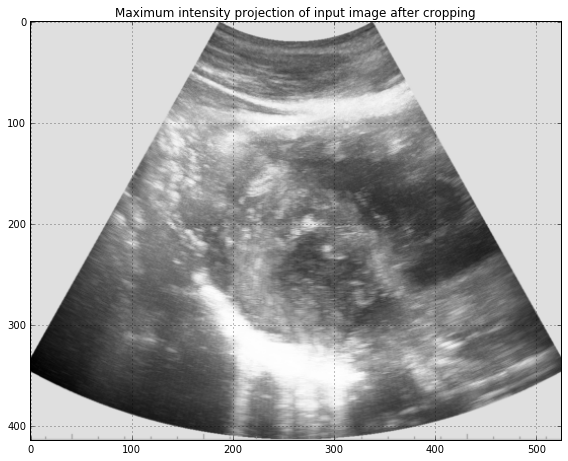

In [9]:
# crop if requested
xBounds = [0, imInput_highres_uncropped.shape[1]]

if xyROI.has_key('min_X'):
    xBounds[0] = xyROI['min_X']    
if xyROI.has_key('max_X'):    
    xBounds[1] = xyROI['max_X']

yBounds = [0, imInput_highres_uncropped.shape[0]]

if xyROI.has_key('min_Y'):
    yBounds[0] = xyROI['min_Y']    
if xyROI.has_key('max_Y'):    
    yBounds[1] = xyROI['max_Y']
    
imInput_highres = imInput_highres_uncropped[yBounds[0]:yBounds[1], xBounds[0]:xBounds[1], :] 
imInput_highres_prenoise = imInput_highres

print '\nImage Size After Cropping: ', imInput_highres.shape

# show mip
plt.figure()
plt.imshow(imInput_highres.max(2))
plt.title('Maximum intensity projection of input image after cropping')

In [10]:
# make results dir
resultFilePrefix = dataFiles['prefix'][datasetId]

resultsDir = os.path.join(resultsRootDir, 
                          os.path.split( os.path.abspath(dataRootDir) )[1], 
                          dataFiles['prefix'][datasetId])
if not os.path.exists(resultsDir):
    os.makedirs(resultsDir)
    
print 'Results store directory: ', resultsDir    

Results store directory:  results/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151146


In [52]:
# write original input video
writeVideoToFile(normalizeArray( AddTextOnVideo(imInput_highres, 'Input - %.2f fps' % framesPerSec) ) * 255, 
                 os.path.join(resultsDir, 'Input_highres.avi'), 
                 codec='DIVX', fps=framesPerSec)

True
Writing video results/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151146/Input_highres.avi took 2.44403982162 seconds


In [ ]:
# show video
cvShowVideo(normalizeArray(imInput_highres), 'Input Video', resizeAmount=resizeAmount)

# Artificially downsample the data along the time dimension

In [11]:
#set parameters
timeDownsamplingFrameStep = 3

assert(timeDownsamplingFrameStep >= 1 and (timeDownsamplingFrameStep - np.floor(timeDownsamplingFrameStep) == 0))
       
# downsample the data by the specified amount
imInput = imInput_highres[:, :, ::timeDownsamplingFrameStep]

framesPerSecDownsmp = framesPerSec * (1.0 / timeDownsamplingFrameStep)

print '\nImage Size before downsampling in time: ', imInput_highres.shape
print 'Image Size after downsampling in time: ', imInput.shape

print '\nFrames per sec before downsampling in time: ', framesPerSec
print 'Frames per sec after downsampling in time: ', framesPerSecDownsmp


Image Size before downsampling in time:  (414, 525, 497)
Image Size after downsampling in time:  (414, 525, 166)

Frames per sec before downsampling in time:  35.8333333333
Frames per sec after downsampling in time:  11.9444444444


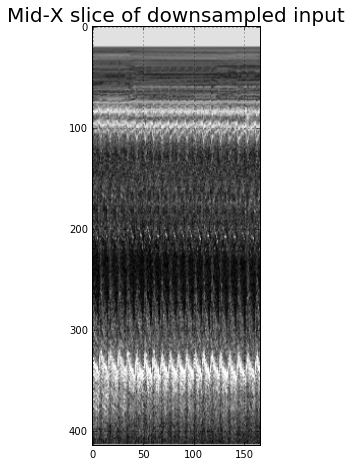

In [12]:
# show mid XT slice of downsampled input before and after noise
plt.figure()

plt.imshow(imInput[:, imInput.shape[1]/2, :])
plt.title('Mid-X slice of downsampled input', fontsize=titlesize)

In [13]:
# write our result
writeVideoToFile(normalizeArray( AddTextOnVideo(imInput, 'Input - %.2f fps' % framesPerSecDownsmp) ) * 255, 
                 os.path.join(resultsDir, 'Input.avi'), 
                 codec='DIVX', fps=framesPerSecDownsmp)

True
Writing video results/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151146/Input.avi took 0.691023111343 seconds


In [ ]:
cvShowVideo([normalizeArray(imInput_highres), normalizeArray(imInput)],
            ['Input high-res video', 'Input artifical low-res video'], resizeAmount=resizeAmount)

### Run the algorithm

In [14]:
import USGatingAndSuperResolution as superUS

In [ ]:
algo = superUS.USGatingAndSuperResolution(xyDownsamplingFactor=0.5, lrconvtol=1e-4)
algo.setInput(imInput)
algo.process() 

Input video size:  (414, 525, 166)

>> Step-1: Suppressing noise using low-rank plus sparse decomposition ...

[iter: 0000]: rank(P) = 0001, |C|_0 = 0000, crit=43334.2784126623, total sparse =0000
[iter: 0010]: rank(P) = 0010, |C|_0 = 10559021, crit=9582.5118307136, total sparse =145976595
[iter: 0020]: rank(P) = 0018, |C|_0 = 22954922, crit=35.0261274219, total sparse =203533506
[iter: 0030]: rank(P) = 0019, |C|_0 = 23442834, crit=0.3126051695, total sparse =203578111
[iter: 0040]: rank(P) = 0019, |C|_0 = 23511364, crit=0.0032984170, total sparse =203578114
[iter: 0050]: rank(P) = 0019, |C|_0 = 23494796, crit=0.0022620693, total sparse =203578098
[iter: 0060]: rank(P) = 0019, |C|_0 = 23477764, crit=0.0018197885, total sparse =203578085
[iter: 0070]: rank(P) = 0019, |C|_0 = 23468036, crit=0.0014966725, total sparse =203578075
[iter: 0080]: rank(P) = 0019, |C|_0 = 23461097, crit=0.0012645323, total sparse =203578066
[iter: 0090]: rank(P) = 0019, |C|_0 = 23455275, crit=0.0011169994, tota

In [ ]:
# retrieve noise suppression results
imD = algo.imD_
imLowRank = algo.imLowRank_
imSparse = algo.imSparse_

# retrieve phase estimation results
X_proj = algo.X_proj_
simMat = algo.simMat_
simMat_Trend = algo.simMat_Trend_
simMat_Seasonal = algo.simMat_Seasonal_
spectralEntropy = algo.spectralEntropy_
fid_best = algo.fid_best_

ts = algo.ts_
ts_trend = algo.ts_trend_
ts_seasonal = algo.ts_seasonal_
period = algo.period_

ts_analytic = algo.ts_analytic_
ts_instaamp = algo.ts_instaamp_
ts_instaphase = algo.ts_instaphase_
ts_instaphase_nmzd = algo.ts_instaphase_nmzd_

### Results for MICCAI

#### Figures depicting noise suppression

In [ ]:
#
# Show MIPs of Input, Lowrank and Sparse parts
#
dispframe = 0

# Input
plt.figure(figsize=(20,15))

plt.subplot(141)
mplotShowImage(imInput[:, :, dispframe])
plt.title('Input', fontsize=labelsize)
SaveImageToDisk(imInput.max(2), resultsDir, 'imInput')

# smoothed input
plt.subplot(142)
mplotShowImage(imD[:, :, dispframe])
plt.title('Median', fontsize=labelsize)
SaveImageToDisk(imD.max(2), resultsDir, 'imMedian')

# Low Rank
plt.subplot(143)
mplotShowImage(imLowRank[:, :, dispframe])
plt.title('Low-rank', fontsize=labelsize)
SaveImageToDisk(imLowRank.max(2), resultsDir, 'imLowRank')

# Sparse
plt.subplot(144)
mplotShowImage(imSparse[:, :, dispframe])
plt.title('Sparse', fontsize=labelsize)
SaveImageToDisk(imSparse.max(2), resultsDir, 'imSparse')

#
# Show Mid XT slices of Input, Lowrank and Sparse parts
#

# Input
plt.figure(figsize=(20, 10))

plt.subplot(221)

mplotShowImage(imInput[:, imInput.shape[1]/2, :])
plt.title('Mid-X slice of input', fontsize=titlesize)
plt.xlabel('Time', fontsize=labelsize)
plt.ylabel('Y', fontsize=labelsize)
SaveImageToDisk(imInput[:, imInput.shape[1]/2, :], resultsDir, 'imInput_MidX')

# Smoothed Input
plt.subplot(222)

mplotShowImage(imD[:, imD.shape[1]/2, :])
plt.title('Mid-X slice of input median', fontsize=titlesize)
plt.xlabel('Time', fontsize=labelsize)
plt.ylabel('Y', fontsize=labelsize)
SaveImageToDisk(imD[:, imD.shape[1]/2, :], resultsDir, 'imMedian_MidX')

# Low Rank
plt.subplot(223)

mplotShowImage(imLowRank[:, imLowRank.shape[1]/2, :])
plt.title('Mid-X slice of lowrank part', fontsize=titlesize)
plt.xlabel('Time', fontsize=labelsize)
plt.ylabel('Y', fontsize=labelsize)
SaveImageToDisk(imLowRank[:, imLowRank.shape[1]/2, :], resultsDir, 'imLowRank_MidX')

# Sparse
plt.subplot(224)

mplotShowImage(imSparse[:, imSparse.shape[1]/2, :])
plt.title('Mid-X slice of sparse part', fontsize=titlesize)
plt.xlabel('Time', fontsize=labelsize)
plt.ylabel('Y', fontsize=labelsize)
SaveImageToDisk(imSparse[:, imSparse.shape[1]/2, :], resultsDir, 'imSparse_MidX')

#### Figures depicting phase estimation

In [ ]:
curlinewidth = 6
curmarkersize = 15
curlabelsize = 48

#
# plot the whole similarity landscape along with its trend and seasonal parts
#
fig, ax = plt.subplots(1, 3)

ax[0].imshow(simMat)
ax[0].set_title('Similarity - raw')
SaveImageToDisk(simMat, resultsDir, 'simMat')

ax[1].imshow(simMat_Trend)
ax[1].set_title('Similarity - trend')
SaveImageToDisk(simMat_Trend, resultsDir, 'simMat_Trend')

ax[2].imshow(simMat_Seasonal)
ax[2].set_title('Similarity - seasonal')
SaveImageToDisk(simMat_Seasonal, resultsDir, 'simMat_Seasonal')

# Show detrended similarity
plt.figure()
plt.plot(normalizeArray(ts_seasonal) , '-o', markersize=curmarkersize, linewidth=curlinewidth)
plt.legend(fontsize=curlabelsize)
plt.xlabel('time', fontsize=curlabelsize)
plt.ylabel('Similarity', fontsize=curlabelsize)
plt.xlim([0, ts_seasonal.size])
plt.tight_layout()
SaveFigToDisk(resultsDir, 'ts_seasonal', bbox_inches='tight')

# show periodogram
plt.figure()
freq, power = scipy.signal.periodogram(ts_seasonal)
beatsPerMinute = algo.period_ * 60.0 / framesPerSecDownsmp
print "beats per minute at %f fps = %f" % (framesPerSecDownsmp, beatsPerMinute)
maxPowerLoc = np.argmax(power)

plt.plot(freq, power, linewidth=curlinewidth, label='Periodogram')
plt.plot([freq[maxPowerLoc], freq[maxPowerLoc]], 
           [0, power[maxPowerLoc]], 'g', linewidth=curlinewidth, label='Estimated Period')
plt.text(freq[maxPowerLoc], power[maxPowerLoc], 
           'Period = %.3f frames, \n No. of periods = %d' % (period, ts_seasonal.size / period), 
            fontsize=curlabelsize/2, color='r')
plt.xlabel('frequency', fontsize=curlabelsize)
plt.ylabel('power', fontsize=curlabelsize)
plt.legend(fontsize=curlabelsize)
plt.tight_layout()
SaveFigToDisk(resultsDir, 'periodogram')

# show instantaneous phase 
plt.figure()

plt.plot(ts_instaphase_nmzd, '-o', 
         markersize = curmarkersize, linewidth=curlinewidth, label='estimated phase')
plt.xlabel('time', fontsize=curlabelsize)
plt.ylabel('Phase', fontsize=curlabelsize)
plt.xlim([0, ts_instaphase_nmzd.size])
plt.tight_layout()
SaveFigToDisk(resultsDir, 'ts_instaphase')

# order input sequence by estimated phase
phaseord_est = np.argsort(ts_instaphase_nmzd)
imInput_phaseord_est = imInput[:,:,phaseord_est]
imLowrank_phaseord_est = imLowRank[:,:,phaseord_est]

consec_frame_mrmse_input = superUS.compute_mean_consec_frame_rmse(imInput)
print '\nMean consective frame RMSE of input = ', consec_frame_mrmse_input

consec_frame_mncorr_input = superUS.compute_mean_consec_frame_ncorr(imInput)
print 'Mean consecutive frame ncorr of input = ', consec_frame_mncorr_input

consec_frame_mrmse_input_phord_est = superUS.compute_mean_consec_frame_rmse(imInput_phaseord_est)
print '\nMean consective frame RMSE of input ordered by estimate phase = ', \
       consec_frame_mrmse_input_phord_est

consec_frame_mncorr_input_phord_est = superUS.compute_mean_consec_frame_ncorr(imInput_phaseord_est)
print 'Mean consective frame ncorr of input ordered by estimate phase = ', \
       consec_frame_mncorr_input_phord_est

# show image sequence ordered by estimated phase
plt.figure()

plt.subplot(121)
plt.imshow(imInput_phaseord_est[:, imInput_phaseord_est.shape[1]/2, :].T)
plt.title('Mid-YT slice of input ordered by estimated phase', fontsize=labelsize)
plt.xlabel('Time', fontsize=curlabelsize)
plt.ylabel('X', fontsize=curlabelsize)
SaveImageToDisk(imInput_phaseord_est[:, imInput_phaseord_est.shape[1]/2, :].T, 
                resultsDir, 'Input_est_phaseord_MidX')

plt.subplot(122)
plt.imshow(imLowrank_phaseord_est[:, imLowrank_phaseord_est.shape[1]/2, :].T)
plt.title('Mid-YT slice of lowrank ordered by estimated phase', fontsize=labelsize)
plt.xlabel('Time', fontsize=curlabelsize)
plt.ylabel('X', fontsize=curlabelsize)
SaveImageToDisk(imLowrank_phaseord_est[:, imLowrank_phaseord_est.shape[1]/2, :].T, 
                resultsDir, 'Lowrank_est_phaseord_MidX')

In [ ]:
# create a matrix where each row represents one frame
X = np.reshape(imInput, (np.prod(imInput.shape[:2]), imInput.shape[-1])).T

# perform pca on X
print 'Reducing dimensionality using PCA ... ', 

tPCA_Start = time.time()

pca = sklearn.decomposition.PCA(n_components = algo.pca_n_components)

X_proj = pca.fit_transform(X)

tPCA_End = time.time()

numEigenVectors = pca.n_components_

print 'took {} seconds'.format(tPCA_End - tPCA_Start)
print '%d eigen vectors were needed to cover %.2f%% of variance' % (numEigenVectors, 
                                                                    algo.pca_n_components * 100)

# compute mean consequent frame PCA space distance of input video
numFrames = imInput.shape[2]

mean_conseq_frame_dist_input = 0

for fid in range(numFrames-1):
    curFrameProj = X_proj[fid, :numEigenVectors]
    nextFrameProj = X_proj[fid+1, :numEigenVectors]
    curDist = np.sqrt(np.sum((nextFrameProj - curFrameProj)**2))
    
    mean_conseq_frame_dist_input += curDist
    
mean_conseq_frame_dist_input /= numFrames

print 'Mean consecutive frame PCA space distance of input video = ', mean_conseq_frame_dist_input

# compute mean consequent frame PCA space distance of input video ordered by estimated phase
mean_conseq_frame_dist_input_phaseord = 0

X_proj_phase_ord = X_proj[np.argsort(ts_instaphase_nmzd), :]

for fid in range(numFrames-1):
    curFrameProj = X_proj_phase_ord[fid, :numEigenVectors]
    nextFrameProj = X_proj_phase_ord[fid+1, :numEigenVectors]
    curDist = np.sqrt(np.sum((nextFrameProj - curFrameProj)**2))
    
    mean_conseq_frame_dist_input_phaseord += curDist
    
mean_conseq_frame_dist_input_phaseord /= numFrames

print 'Mean consecutive frame PCA space distance of input video ordered by estimated phase = ', \
      mean_conseq_frame_dist_input_phaseord

# compute mean consequent frame PCA space distance of input video randomly ordered
mean_conseq_frame_dist_input_randord = 0

X_proj_rand_ord = X_proj[np.random.permutation(numFrames), :]

for fid in range(numFrames-1):
    curFrameProj = X_proj_rand_ord[fid, :numEigenVectors]
    nextFrameProj = X_proj_rand_ord[fid+1, :numEigenVectors]
    curDist = np.sqrt(np.sum((nextFrameProj - curFrameProj)**2))
    
    mean_conseq_frame_dist_input_randord += curDist
    
mean_conseq_frame_dist_input_randord /= numFrames

print 'Mean consecutive frame PCA space distance of input video randomly ordered = ', \
      mean_conseq_frame_dist_input_randord    

#### Video depicting noise suppression

In [ ]:
# make tiled video of Input, Median Filtered Input, Low-Rank, Sparse
imNoiseSuppressionVideo = np.zeros_like( np.tile(imInput, (2, 2, 1)) )

rsize, csize, nframes  = imInput.shape
imNoiseSuppressionVideo[:rsize, :csize, :] = AddTextOnVideo( imInput, 'Input' )
imNoiseSuppressionVideo[:rsize, csize:, :] = AddTextOnVideo( imD, 'Median Filtered' )
imNoiseSuppressionVideo[rsize:, :csize, :] = AddTextOnVideo( imLowRank, 'Low-rank' )
imNoiseSuppressionVideo[rsize:, csize:, :] = AddTextOnVideo( normalizeArray(imSparse) * 255, 'Sparse' )

# show mip
plt.figure()
plt.imshow(imNoiseSuppressionVideo.max(2))

In [ ]:
# write our result
writeVideoToFile(normalizeArray(imNoiseSuppressionVideo) * 255, 
                 os.path.join(resultsDir, 'NoiseSuppressionResult.avi'), 
                 codec='DIVX', fps=framesPerSecDownsmp)

#### Video depicting phase estimation

In [ ]:
# make tiled video of Input and LowRank ordered by estimated phase
imPhaseEstimationVideo = np.zeros_like( np.tile(imInput, (1, 2, 1)) )

rsize, csize, nframes  = imInput.shape

imPhaseEstimationVideo[:rsize, :csize, :] = AddTextOnVideo( imInput_phaseord_est, 'Phase-ordered Input' )
imPhaseEstimationVideo[:rsize, csize:, :] = AddTextOnVideo( imLowrank_phaseord_est, 'Phase-ordered Low-rank' )

# show mip
plt.figure()
plt.imshow(imPhaseEstimationVideo[:, :, dispframe])

In [ ]:
# write our result
writeVideoToFile(normalizeArray(imPhaseEstimationVideo) * 255, 
                 os.path.join(resultsDir, 'PhaseEstimationResult.avi'), 
                 codec='DIVX', fps=framesPerSecDownsmp)

#### Video depicting super-resolution

In [ ]:
import USGatingAndSuperResolution as superUS

In [ ]:
# set parmeters
upsampleAmountList = [2, 4, 8]

linear_interp_params = superUS.config_framegen_using_linear_interpolation()
bspline_reg_params = superUS.config_framegen_using_bspline_registration()

mparams_list = [bspline_reg_params, linear_interp_params]

# generate one-period video at higher resolution
for upsampleAmount in upsampleAmountList:    
    for mparams in mparams_list:
        
        print 'upsampling by %d using %s' % (upsampleAmount, mparams['name'])

        numOutFrames = np.uint(upsampleAmount * period + 0.5)        

        imCurOnePeriodVideo_Input = algo.generateSinglePeriodVideo(numOutFrames, imInput=imInput, method=mparams)
        imCurOnePeriodVideo_Lowrank = algo.generateSinglePeriodVideo(numOutFrames, imInput=imLowRank, method=mparams)

        imCurOnePeriodVideo = np.zeros_like(np.tile(imCurOnePeriodVideo_Input, (1, 2, 1)))
        rsize, csize, nframes  = imCurOnePeriodVideo_Input.shape

        imCurOnePeriodVideo[:rsize, :csize, :] = AddTextOnVideo( imCurOnePeriodVideo_Input,
                                                                 'Input Mag %d' % upsampleAmount )
        imCurOnePeriodVideo[:rsize, csize:, :] = AddTextOnVideo( imCurOnePeriodVideo_Lowrank,
                                                                 'Low-rank Mag %d' % upsampleAmount )
        writeVideoToFile(normalizeArray(imCurOnePeriodVideo) * 255, 
                         os.path.join(resultsDir, 
                                      'OnePeriodVideo_Mag_%d_%s.avi' % (upsampleAmount, mparams['name']) ), 
                         codec='DIVX', fps=framesPerSecDownsmp)

        plt.figure()

        plt.subplot(1, 2, 1)    
        plt.imshow(imCurOnePeriodVideo_Input[:, csize/2, :].T)
        plt.title('Input x %d - %s' % (upsampleAmount, mparams['name']), fontsize=titlesize)

        plt.subplot(1, 2, 2)    
        plt.imshow(imCurOnePeriodVideo_Lowrank[:, csize/2, :].T)
        plt.title('Lowrank x %d - %s' % (upsampleAmount, mparams['name']), fontsize=titlesize)
        
        print '\n'

### Validate super-resolution

In [ ]:
import USGatingAndSuperResolution as superUS

def validate_super_resolution(imCurInput_highres, framesPerSec, downSampleFactorList, 
                              methodList=None, xyDownsamplingFactor=0.5):

    if methodList is None:
        kreg_params = superUS.config_framegen_using_kernel_regression()
        optflow_params = superUS.config_framegen_using_optical_flow()
        linear_interp_params = superUS.config_framegen_using_linear_interpolation()
        methodList = [kreg_params, optflow_params, linear_interp_params]
    
    numDownsmpFactors = len(downSampleFactorList)
    numMethods = len(methodList)
    
    methodNameList = [method['name'] for method in methodList]
    
    ncorrStats = np.zeros((numDownsmpFactors, numMethods))
    rmseStats = np.zeros((numDownsmpFactors, numMethods))

    prevPercent = 0
    iter = 0

    tTotal = time.time()

    for did in range(numDownsmpFactors) :

        curDownsamplingFactor = downSampleFactorList[did]

        print '\n\n**********************************************************'
        print 'Validating %dx upsampling' % curDownsamplingFactor
        print '**************************************************************'

        tDownsmp = time.time()
        
        # apply down sampling
        print '\n >>> Applying downsampling ...\n'

        timeDownsamplingFrameStep = curDownsamplingFactor

        assert(timeDownsamplingFrameStep >= 1 and 
               (timeDownsamplingFrameStep - np.floor(timeDownsamplingFrameStep) == 0))

        imCurInput = imCurInput_highres[:, :, ::timeDownsamplingFrameStep]

        curFramesPerSecDownsmp = framesPerSec * (1.0 / timeDownsamplingFrameStep)

        print '\nImage Size before downsampling in time: ', imCurInput_highres.shape
        print 'Image Size after downsampling in time: ', imCurInput.shape

        print '\nFrames per sec before downsampling in time: ', framesPerSec
        print 'Frames per sec after downsampling in time: ', curFramesPerSecDownsmp        

        # run our phase esimation algorithm
        print '\n>>> Running our phase estimation algorithm ...\n'

        algo = superUS.USGatingAndSuperResolution(xyDownsamplingFactor=xyDownsamplingFactor, lrconvtol=1e-4)
        algo.setInput(imCurInput)
        algo.process()

        # compute phase values of dropped frames
        numFramesHRes = imCurInput_highres.shape[2]
        phaseValsHRes = np.zeros(numFramesHRes)
        
        droppedInd = []
        for i in range(imCurInput.shape[2]-1):
            p1 = algo.ts_instaphase_nmzd_[i]
            p2 = algo.ts_instaphase_nmzd_[i+1]
           
            pdist = superUS.phaseDist(p1, p2)
            pstep = pdist / timeDownsamplingFrameStep
            
            for j in range(timeDownsamplingFrameStep):
                curpind = i * timeDownsamplingFrameStep + j
                phaseValsHRes[curpind] = (p1 + pstep * j) % 1
                
                if j > 0:
                    droppedInd.append(curpind)
         
        phaseValsDropped = phaseValsHRes[np.ix_(droppedInd)]
        
        numDroppedFrames = len(droppedInd)
        
        # get dropped frames
        imDropped = np.squeeze(imCurInput_highres[:, :, np.ix_(droppedInd)])
        print 'Dropped video shape: ', imDropped.shape
        
        # reconsrtuct dropped frames using each method and report error
        for mid in range(numMethods):

            cur_mparams = methodList[mid]
            
            print '\n>>> Reconstructing dropped frames using %s ...\n' % cur_mparams['name']

            # reconstruct dropped frames from low-res data
            imDroppedRecon = algo.generateFramesFromPhaseValues(phaseValsDropped, method=cur_mparams)
            print 'Reconstructed dropped video shape: ', imDroppedRecon.shape
            
            # compute error
            mean_ncorr = 0.0
            mean_rmse = 0.0
            
            for i in range(numDroppedFrames):
                mean_ncorr += superUS.ncorr(imDropped[:, :, i], imDroppedRecon[:, :, i])
                mean_rmse += superUS.rmse(imDropped[:, :, i], imDroppedRecon[:, :, i])
                
            mean_ncorr /= numDroppedFrames
            mean_rmse /= numDroppedFrames
            
            print 'Mean NCORR of reconstruction using %s = %f' % (cur_mparams['name'], mean_ncorr)
            print 'Mean RMSE of reconstruction using %s = %f' % (cur_mparams['name'], mean_rmse)
            
            ncorrStats[did, mid] = mean_ncorr
            rmseStats[did, mid] = mean_rmse
            
        # update progress
        iter += 1

        curPercent = np.floor(100.0*iter/(numDownsmpFactors) )
        if curPercent > prevPercent:
            prevPercent = curPercent
            print '%.2d%%' % curPercent,         

        print 'Validation of %dx upsampling took %.2f seconds' % (curDownsamplingFactor,
                                                                  time.time() - tDownsmp)
            
    print 'The entire validation took a total of %.2f seconds' % (time.time() - tTotal)
    
    print 'Method List: ', methodNameList
    
    print 'NCORR stats'
    pprint.pprint(ncorrStats)
    
    print 'RMSE stats'
    pprint.pprint(rmseStats)    
    
validate_super_resolution(imInput_highres, framesPerSec, [2, 3, 4])

### Try Simple Elastix Registration

In [19]:
defaultVal = [str(np.median(imInput[:, 0, 0]))]
pmap_affine = sitk.GetDefaultParameterMap("affine", 4)
pmap_affine["DefaultPixelValue"] = defaultVal
pmap_affine["MaximumNumberOfIterations"] = ["256"]
pmap_affine["Metric"] = ["AdvancedMeanSquares"]

pmap_nonrigid = sitk.GetDefaultParameterMap("nonrigid", 4)
pmap_nonrigid["DefaultPixelValue"] = defaultVal
#pmap_nonrigid["MaximumNumberOfIterations"] = ["256"]
pmap_nonrigid["Metric"] = ["AdvancedMeanSquares"]

plist = sitk.ParameterMapList()
plist.append(pmap_affine)
plist.append(pmap_nonrigid)

sitk.PrettyPrint(plist)

Registration took 9.259731 seconds


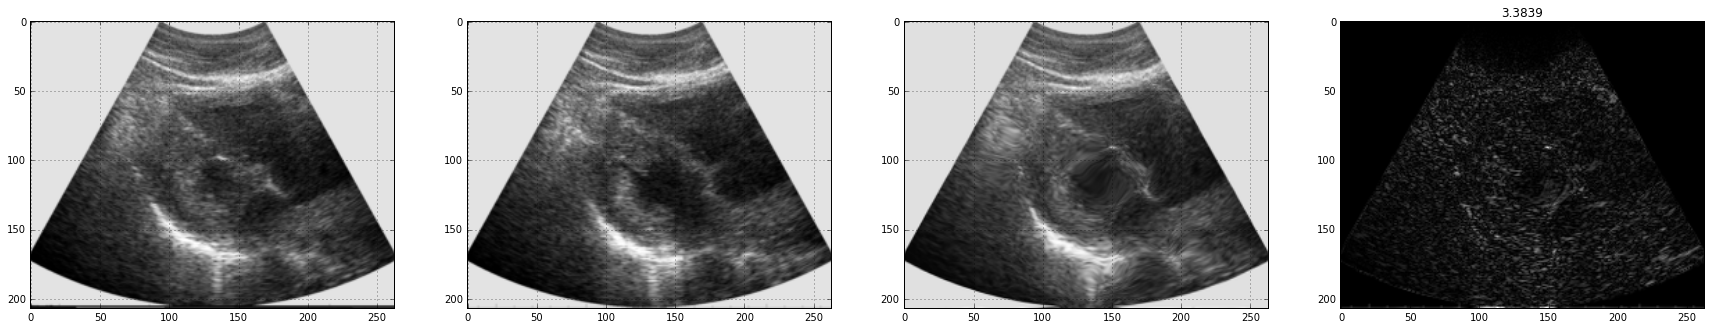

In [24]:
def warp_elastix(im1, im2, pmap):
    
    im1_sitk = sitk.GetImageFromArray(im1)
    im2_sitk = sitk.GetImageFromArray(im2)

    elastix = sitk.SimpleElastix()
    elastix.LogToConsoleOff()
    
    elastix.SetFixedImage(im2_sitk)
    elastix.SetMovingImage(im1_sitk)
    elastix.SetParameterMap(pmap)

    elastix.LogToConsoleOn()
    sitk.PrettyPrint(plist)    
    elastix.LogToConsoleOff()
    
    elastix.Execute()

    imResult = sitk.GetArrayFromImage(elastix.GetResultImage())
    transformParams = elastix.GetTransformParameterMap()
    
    return imResult, transformParams

im1 = imInput[:, :, 0].astype('float32')
im2 = imInput[:, :, 3].astype('float32')

tStart = time.time()
imWarp, params = warp_elastix(im1, im2, plist)
print 'Registration took %f seconds' % (time.time() - tStart)
sitk.PrettyPrint(params)

plt.figure()
plt.subplot(1, 4, 1)
plt.imshow(im1)

plt.subplot(1, 4, 2)
plt.imshow(im2)

plt.subplot(1, 4, 3)
plt.imshow(imWarp)

plt.subplot(1, 4, 4)
plt.imshow(np.abs(imWarp-im2))
plt.title(str(np.median(np.abs(imWarp-im2))))

Registration took 1.660940 seconds


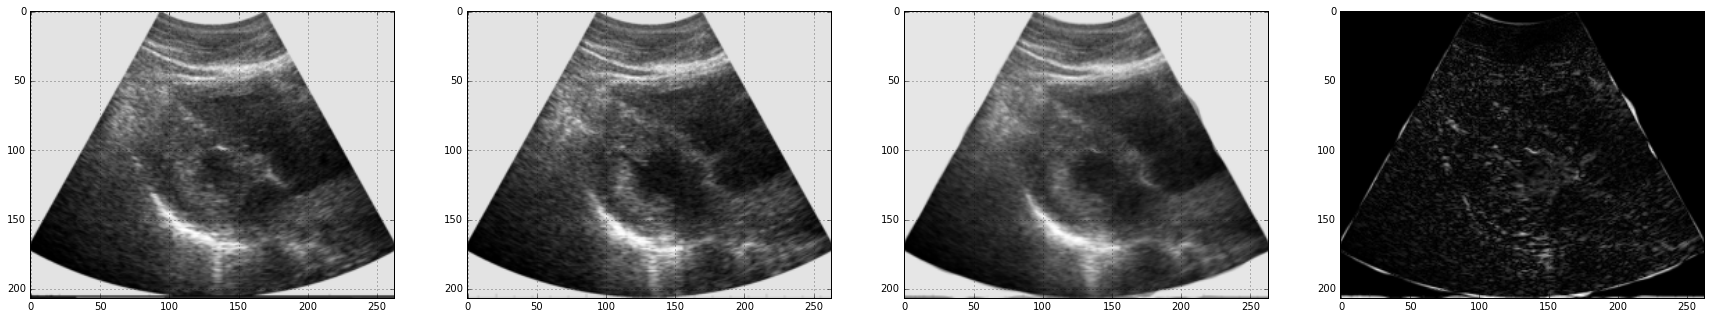

In [32]:
import registration_utilities as ru
import registration_callbacks as rc

def warp_simpleitk(im1, im2, alpha=1, 
                   gridSpacingFactor=0.15, gradConvTol=1e-4, 
                   affineIter=50, bsplineIter=50, debug=False):
    
    moving_image = sitk.GetImageFromArray(im1)
    fixed_image = sitk.GetImageFromArray(im2)
    
    #
    # affine registration
    #
    if debug:
        print '>>> Performing affine registration ...'
    
    affineReg = sitk.ImageRegistrationMethod()
    
    # metric
    affineReg.SetMetricAsMeanSquares()
    affineReg.SetMetricSamplingStrategy(affineReg.RANDOM)
    affineReg.SetMetricSamplingPercentage(0.01)
    
    # interpolator
    affineReg.SetInterpolator(sitk.sitkLinear)
    
    # transform
    initial_transform = sitk.CenteredTransformInitializer(fixed_image, moving_image, 
                                                          sitk.Similarity2DTransform(), 
                                                          sitk.CenteredTransformInitializerFilter.GEOMETRY)
    
    affineReg.SetInitialTransform(initial_transform)
    
    # optimizer
    #affineReg.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=50, estimateLearningRate=affineReg.Once)   
    affineReg.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=gradConvTol, maximumNumberOfIterations=affineIter)
    affineReg.SetOptimizerScalesFromPhysicalShift()
    
    # multi-resolution setup
    affineReg.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    affineReg.SetSmoothingSigmasPerLevel(smoothingSigmas = [2,1,0])
    affineReg.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
   
    # connect all of the observers so that we can perform plotting during registration
    if debug:
        affineReg.AddCommand(sitk.sitkStartEvent, rc.metric_start_plot)
        affineReg.AddCommand(sitk.sitkEndEvent, rc.metric_end_plot)
        affineReg.AddCommand(sitk.sitkMultiResolutionIterationEvent, rc.metric_update_multires_iterations) 
        affineReg.AddCommand(sitk.sitkIterationEvent, lambda: rc.metric_plot_values(affineReg))
    
    # Execute
    affine_transform = affineReg.Execute(fixed_image, moving_image)
    
    if debug:
        print('Final metric value for affine registration: {0}'.format(affineReg.GetMetricValue()))
        print('Optimizer\'s stopping condition, {0}'.format(affineReg.GetOptimizerStopConditionDescription()))

    #
    # Bspline registration
    #
    if debug:
        print '>>> Performing bspline registration ...'
    
    bsplineReg = sitk.ImageRegistrationMethod()
    
    # metric
    bsplineReg.SetMetricAsMeanSquares()
    bsplineReg.SetMetricSamplingStrategy(affineReg.RANDOM)
    bsplineReg.SetMetricSamplingPercentage(0.01)
    
    # interpolator
    bsplineReg.SetInterpolator(sitk.sitkLinear)
    
    # initial transform
    bsplineReg.SetMovingInitialTransform(affine_transform)
    mesh_size = [int(gridSpacingFactor * sz) for sz in fixed_image.GetSize()]
    if debug:
        print mesh_size
    initial_transform = sitk.BSplineTransformInitializer(fixed_image, mesh_size, order=3)
      
    bsplineReg.SetInitialTransform(initial_transform)
    
    # optimizer
    #bsplineReg.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, estimateLearningRate=bsplineReg.Once)   
    bsplineReg.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=gradConvTol, maximumNumberOfIterations=bsplineIter)
    bsplineReg.SetOptimizerScalesFromPhysicalShift()
    
    # multi-resolution setup
    bsplineReg.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    bsplineReg.SetSmoothingSigmasPerLevel(smoothingSigmas = [2,1,0])
    bsplineReg.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
   
    # connect all of the observers so that we can perform plotting during registration
    if debug:
        bsplineReg.AddCommand(sitk.sitkStartEvent, rc.metric_start_plot)
        bsplineReg.AddCommand(sitk.sitkEndEvent, rc.metric_end_plot)
        bsplineReg.AddCommand(sitk.sitkMultiResolutionIterationEvent, rc.metric_update_multires_iterations) 
        bsplineReg.AddCommand(sitk.sitkIterationEvent, lambda: rc.metric_plot_values(bsplineReg))
    
    # Execute
    bspline_transform = bsplineReg.Execute(fixed_image, moving_image)
    
    if debug:
        print('Final metric value: {0}'.format(bsplineReg.GetMetricValue()))
        print('Optimizer\'s stopping condition, {0}'.format(bsplineReg.GetOptimizerStopConditionDescription()))
    
    # compose affine and bspline transform
    final_transform = sitk.Transform(bspline_transform)
    final_transform.AddTransform(affine_transform)
    
    # convert to displacement field image
    disp_field_converter = sitk.TransformToDisplacementFieldFilter()
    disp_field_converter.SetReferenceImage(fixed_image)
    
    disp_field_image = disp_field_converter.Execute(final_transform)
    
    # module displacement field image
    disp_field_image_fwd = sitk.GetImageFromArray(alpha * sitk.GetArrayFromImage(disp_field_image), isVector=True)
    disp_field_image_bck = sitk.GetImageFromArray((1 - alpha) * sitk.GetArrayFromImage(disp_field_image), isVector=True)
    
    # transform moving image
    defaultVal = np.double(np.median(im1[:, 0]))
    
    final_transform_fwd = sitk.DisplacementFieldTransform(disp_field_image_fwd)
    moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform_fwd,
                                     sitk.sitkLinear, defaultVal, fixed_image.GetPixelIDValue())    

    # transform fixed image
    defaultVal = np.double(np.median(im2[:, 0]))
    final_transform_bck = sitk.DisplacementFieldTransform(disp_field_image_bck)
    fixed_resampled = sitk.Resample(fixed_image, fixed_image, final_transform_bck,
                                    sitk.sitkLinear, defaultVal, fixed_image.GetPixelIDValue())    
    
    imResult = 0.5 * (sitk.GetArrayFromImage(fixed_resampled) + sitk.GetArrayFromImage(moving_resampled))
    
    return imResult, final_transform    

im1 = imInput[:, :, 0].astype('float32')
im2 = imInput[:, :, 3].astype('float32')

tStart = time.time()
imWarp, final_transform = warp_simpleitk(im1, im2)

print 'Registration took %f seconds' % (time.time() - tStart)

plt.figure()
plt.subplot(1, 4, 1)
plt.imshow(im1)

plt.subplot(1, 4, 2)
plt.imshow(im2)

plt.subplot(1, 4, 3)
plt.imshow(imWarp)

plt.subplot(1, 4, 4)
plt.imshow(np.abs(imWarp-im2))

### Display results of noise suppression using lowrank + sparse decomposition

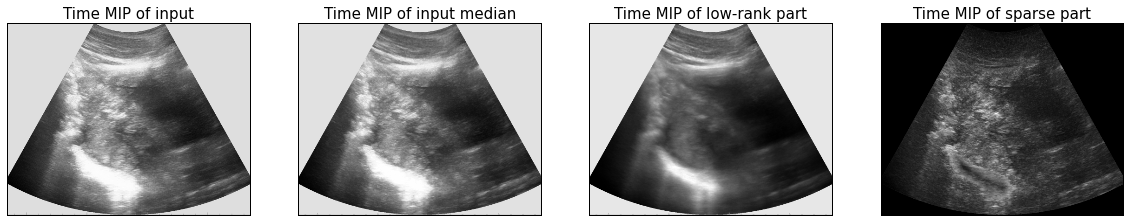

In [22]:
#
# Show MIPs of Input, Lowrank and Sparse parts
#

# Input
plt.figure(figsize=(20,15))

plt.subplot(141)
mplotShowImage(imInput.max(2))
plt.title('Time MIP of input', fontsize=labelsize)
SaveImageToDisk(imInput.max(2), resultsDir, 'imInput_Time_MIP')

# smoothed input
plt.subplot(142)
mplotShowImage(imD.max(2))
plt.title('Time MIP of input median', fontsize=labelsize)
SaveImageToDisk(imD.max(2), resultsDir, 'imD_Time_MIP')

# Low Rank
plt.subplot(143)
mplotShowImage(imLowRank.max(2))
plt.title('Time MIP of low-rank part', fontsize=labelsize)
SaveImageToDisk(imLowRank.max(2), resultsDir, 'imLowRank_Time_MIP')

# Sparse
plt.subplot(144)
mplotShowImage(imSparse.max(2))
plt.title('Time MIP of sparse part', fontsize=labelsize)
SaveImageToDisk(imSparse.max(2), resultsDir, 'imSparse_Time_MIP')

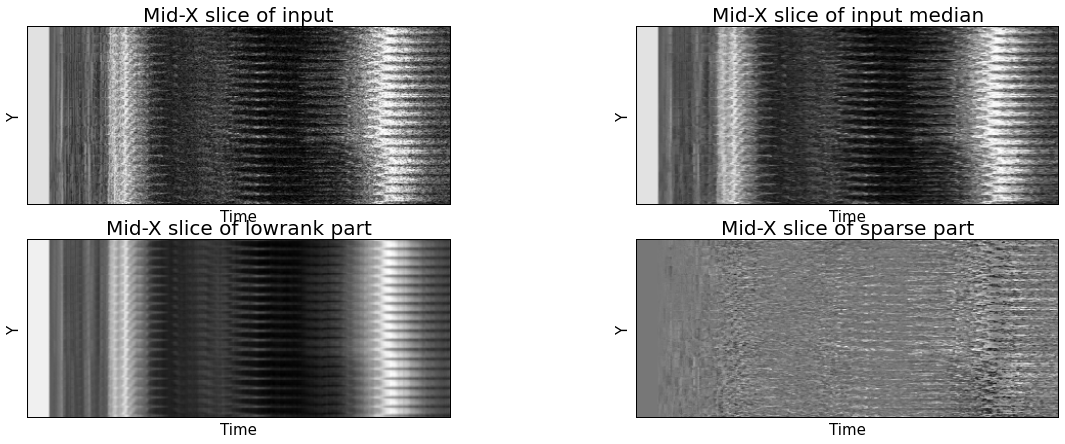

In [23]:
#
# Show Mid XT slices of Input, Lowrank and Sparse parts
#

# Input
plt.figure(figsize=(20, 7))

plt.subplot(221)

mplotShowImage(imInput[:, imInput.shape[1]/2, :].T)
plt.title('Mid-X slice of input', fontsize=titlesize)
plt.xlabel('Time', fontsize=labelsize)
plt.ylabel('Y', fontsize=labelsize)
SaveImageToDisk(imInput[:, imInput.shape[1]/2, :].T, resultsDir, 'imInput_MidX')

# Smoothed Input
plt.subplot(222)

mplotShowImage(imD[:, imD.shape[1]/2, :].T)
plt.title('Mid-X slice of input median', fontsize=titlesize)
plt.xlabel('Time', fontsize=labelsize)
plt.ylabel('Y', fontsize=labelsize)
SaveImageToDisk(imD[:, imD.shape[1]/2, :].T, resultsDir, 'imD_MidX')

# Low Rank
plt.subplot(223)

mplotShowImage(imLowRank[:, imLowRank.shape[1]/2, :].T)
plt.title('Mid-X slice of lowrank part', fontsize=titlesize)
plt.xlabel('Time', fontsize=labelsize)
plt.ylabel('Y', fontsize=labelsize)
SaveImageToDisk(imLowRank[:, imLowRank.shape[1]/2, :].T, resultsDir, 'imLowRank_MidX')

# Sparse
plt.subplot(224)

mplotShowImage(imSparse[:, imSparse.shape[1]/2, :].T)
plt.title('Mid-X slice of sparse part', fontsize=titlesize)
plt.xlabel('Time', fontsize=labelsize)
plt.ylabel('Y', fontsize=labelsize)
SaveImageToDisk(imSparse[:, imSparse.shape[1]/2, :].T, resultsDir, 'imSparse_MidX')


In [238]:
# see video
cvShowVideo([normalizeArray(imD), normalizeArray(imLowRank), normalizeArray(imSparse)], 
            ['Input', 'Low-rank', 'Sparse'], 
            resizeAmount=resizeAmount)

In [25]:
# save results to disk
writeVideoToFile(normalizeArray(imD) * 255, 
                 os.path.join(resultsDir, '%s.D.avi' % resultFilePrefix), 
                 codec='DIVX', fps=framesPerSecDownsmp)
writeVideoToFile(normalizeArray(imLowRank) * 255, 
                 os.path.join(resultsDir, '%s.lowrank.avi' % resultFilePrefix), 
                 codec='DIVX', fps=framesPerSecDownsmp)
writeVideoToFile(normalizeArray(imSparse) * 255, 
                 os.path.join(resultsDir, '%s.sparse.avi' % resultFilePrefix), 
                 codec='DIVX', fps=framesPerSecDownsmp)

True
Writing video /home/cdeepakroy/work/gdrive_kitware/LowCostUltrasound/results/videos/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151027/Heart_20150220_151027.D.avi took 0.53414607048 seconds
True
Writing video /home/cdeepakroy/work/gdrive_kitware/LowCostUltrasound/results/videos/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151027/Heart_20150220_151027.lowrank.avi took 0.44645190239 seconds
True
Writing video /home/cdeepakroy/work/gdrive_kitware/LowCostUltrasound/results/videos/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151027/Heart_20150220_151027.sparse.avi took 0.528232097626 seconds


### Display results of phase estimation

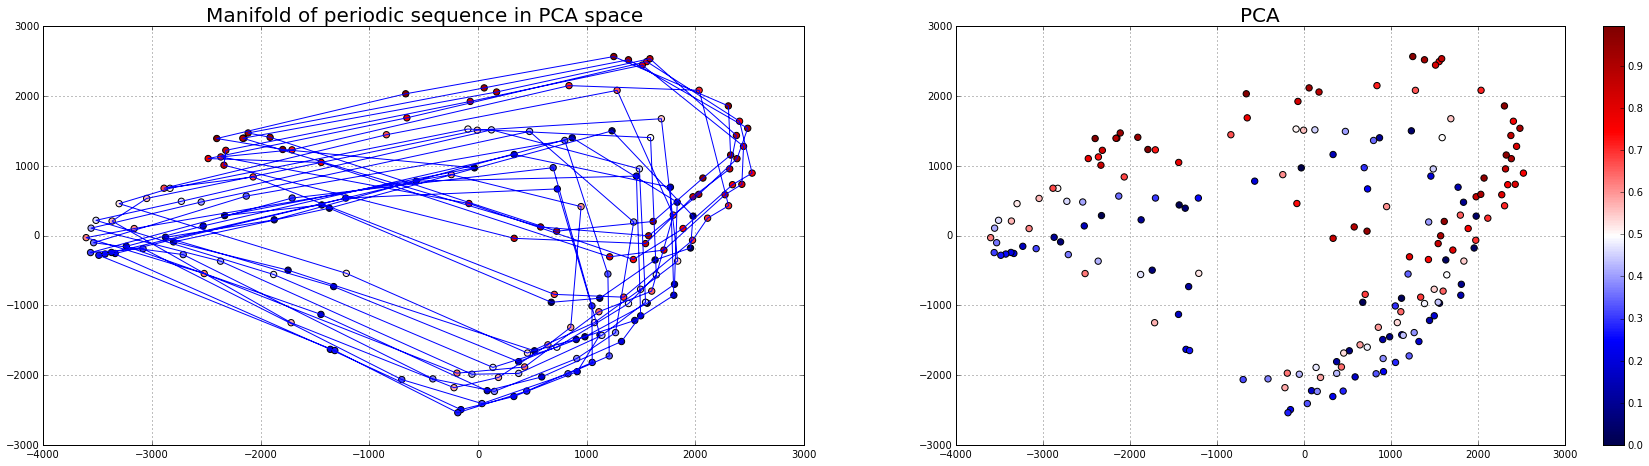

In [26]:
# visualize pca reduced subspace
cmap = plt.cm.seismic
color = np.arange(imInput.shape[2]) / np.float(imInput.shape[2])

fig = plt.figure()

plt.subplot(1, 2, 2)
plt.scatter(X_proj[:, 0], X_proj[:, 1], s=40, c=color, cmap=cmap)
plt.title("PCA", fontsize=titlesize)
plt.colorbar()

plt.subplot(1, 2, 1)
plt.scatter(X_proj[:, 0], X_proj[:, 1], s=40, c=color, cmap=cmap)
t = range(X_proj.shape[0])
t.append(0)
plt.plot(X_proj[t, 0], X_proj[t, 1], '-')
plt.title("Manifold of periodic sequence in PCA space", fontsize=titlesize)       

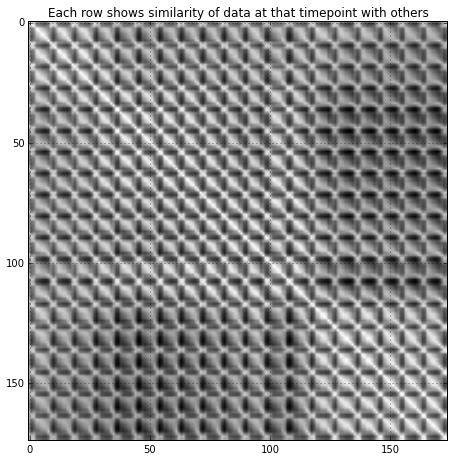

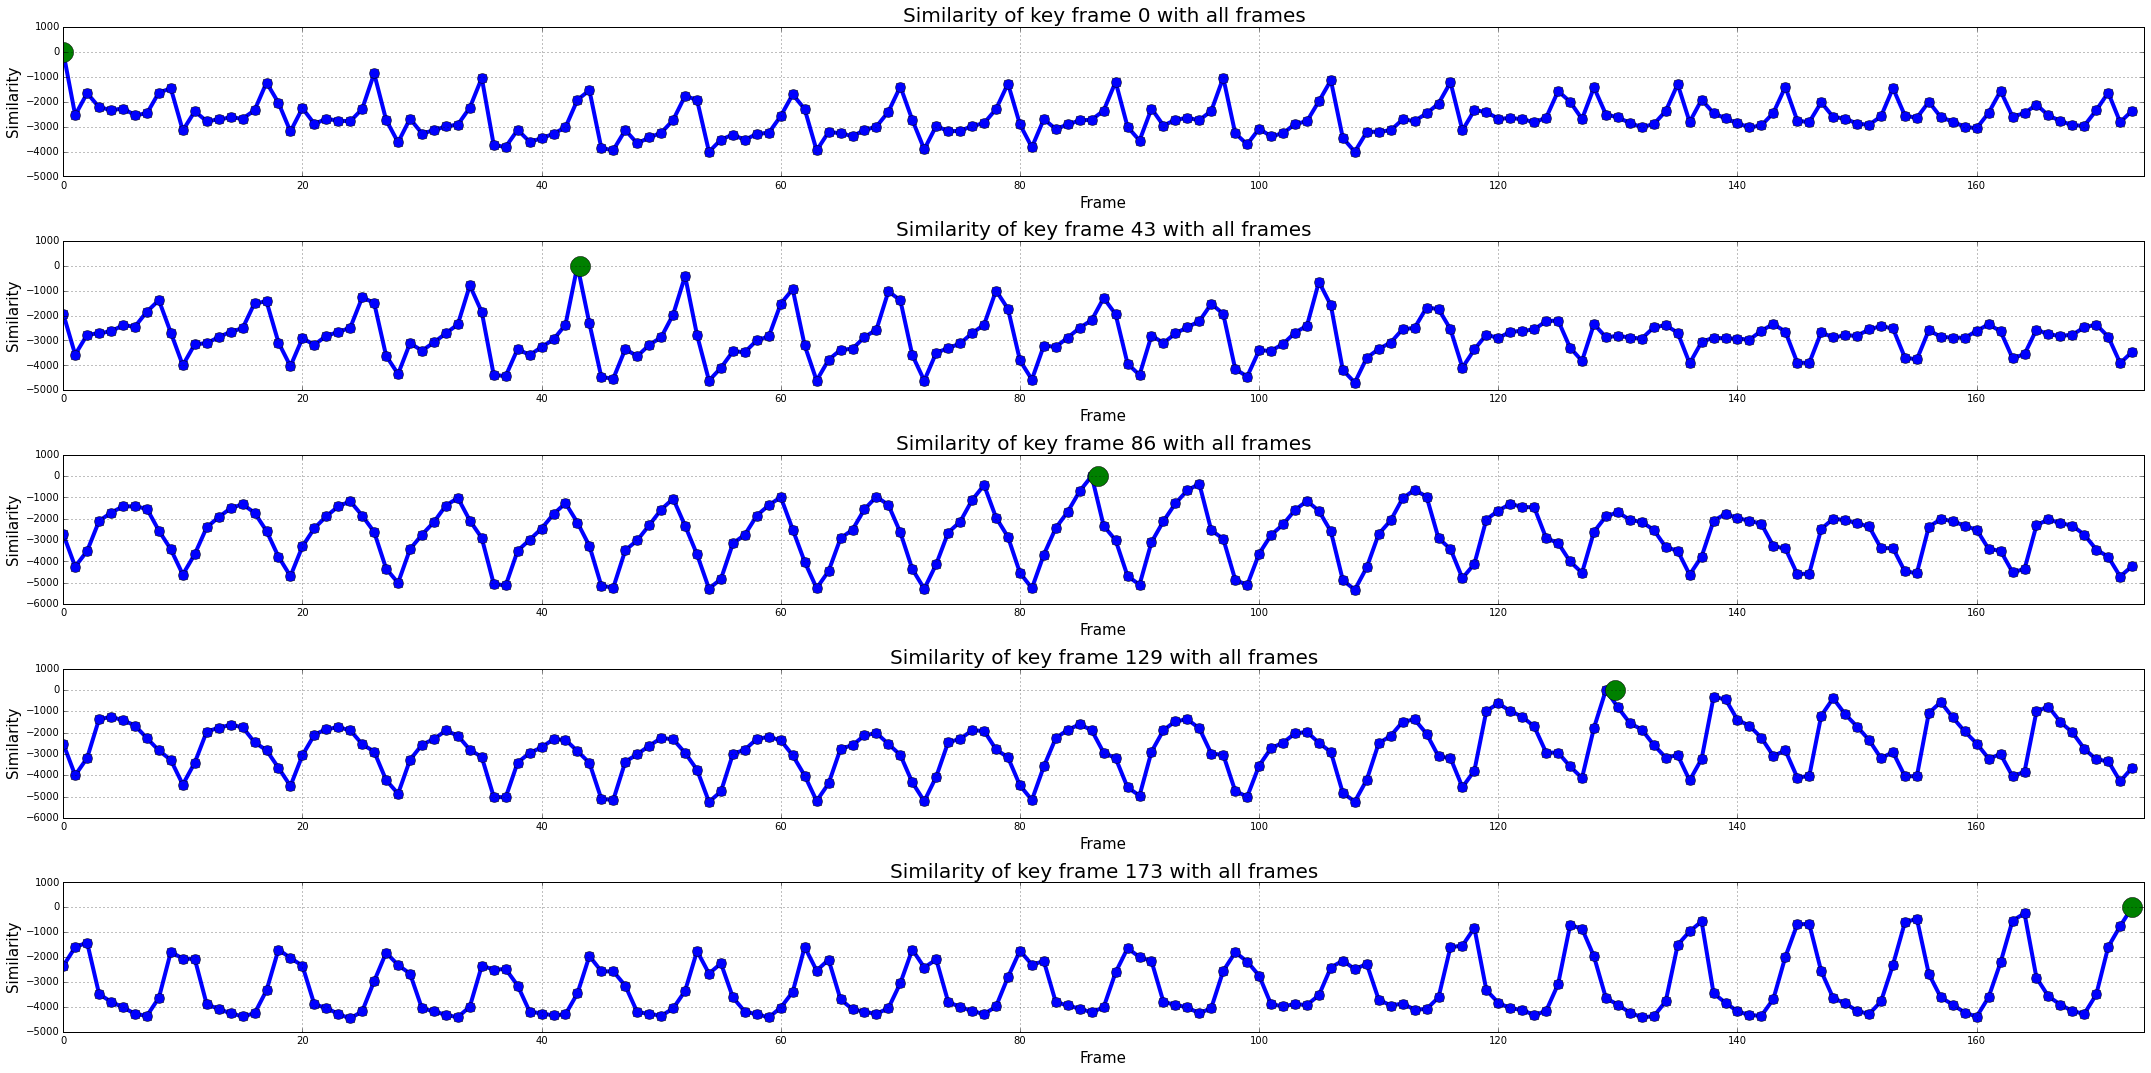

In [27]:
# show the whole similarity landscape       
fig = plt.figure()

plt.imshow(simMat)
plt.title('Each row shows similarity of data at that timepoint with others')

# show similarity landscape of select frames
plt.figure(figsize=(30,15))

keyFrameList = np.linspace(0, imInput.shape[2]-1, 5, endpoint=True)

for i in range(len(keyFrameList)):
    
    keyFrameId = keyFrameList[i]
    
    plt.subplot(len(keyFrameList), 1, i+1)
    
    plt.plot(simMat[keyFrameId, :], '-o', markersize=10, linewidth=4)
    plt.plot(keyFrameId, 1.0, 'o', markersize=20)
    plt.xlabel('Frame', fontsize=labelsize)
    plt.ylabel('Similarity', fontsize=labelsize)
    #plt.ylim([simFrame.min()-0.01, 1.0])     
    plt.xlim([0, simMat.shape[1]])
    plt.title('Similarity of key frame %d with all frames' % keyFrameId, fontsize=titlesize)   
    
plt.tight_layout()    

beats per minute at 11.944444 fps = 46.002448


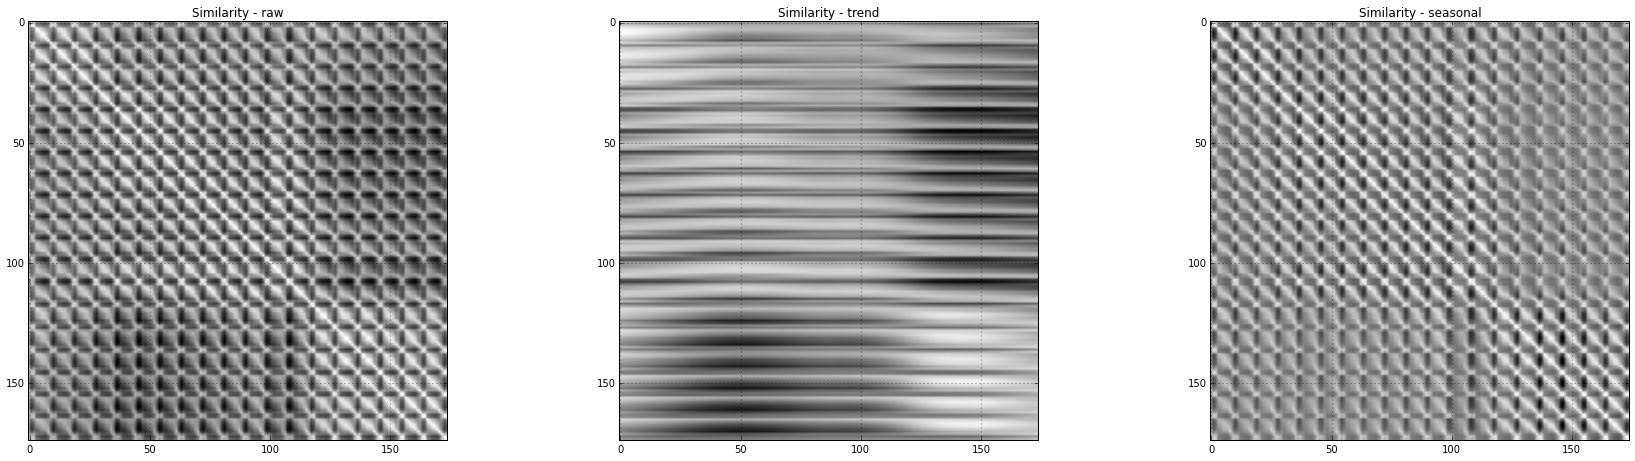

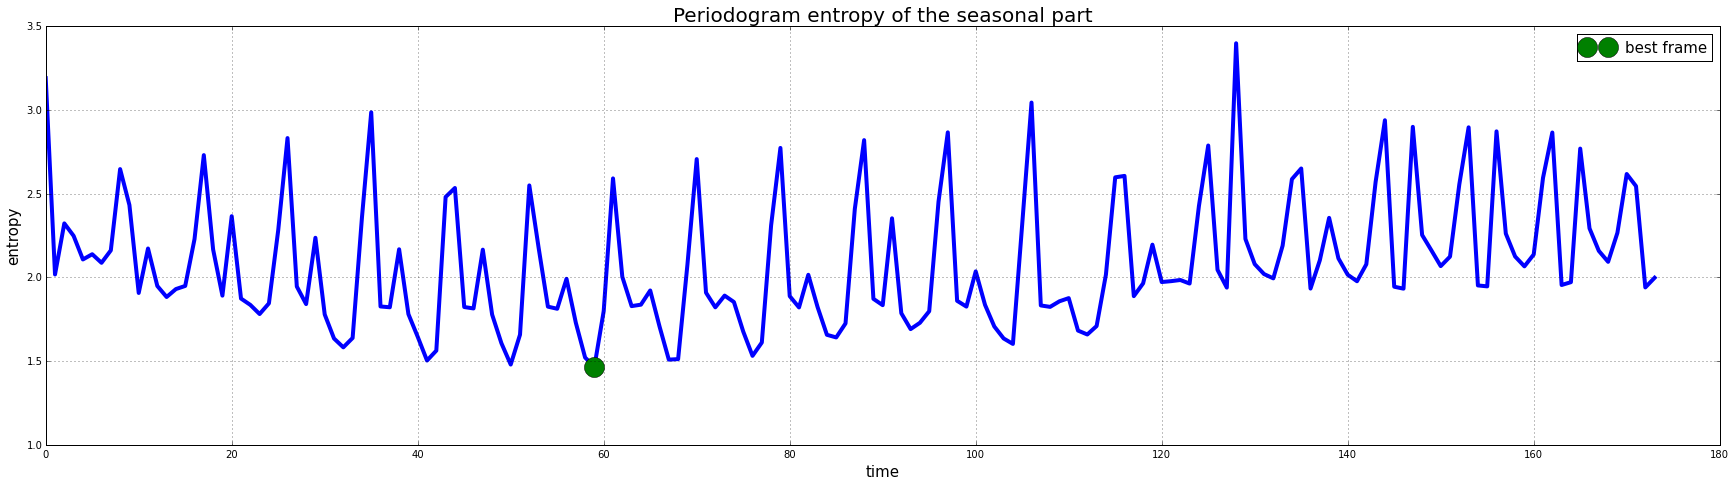

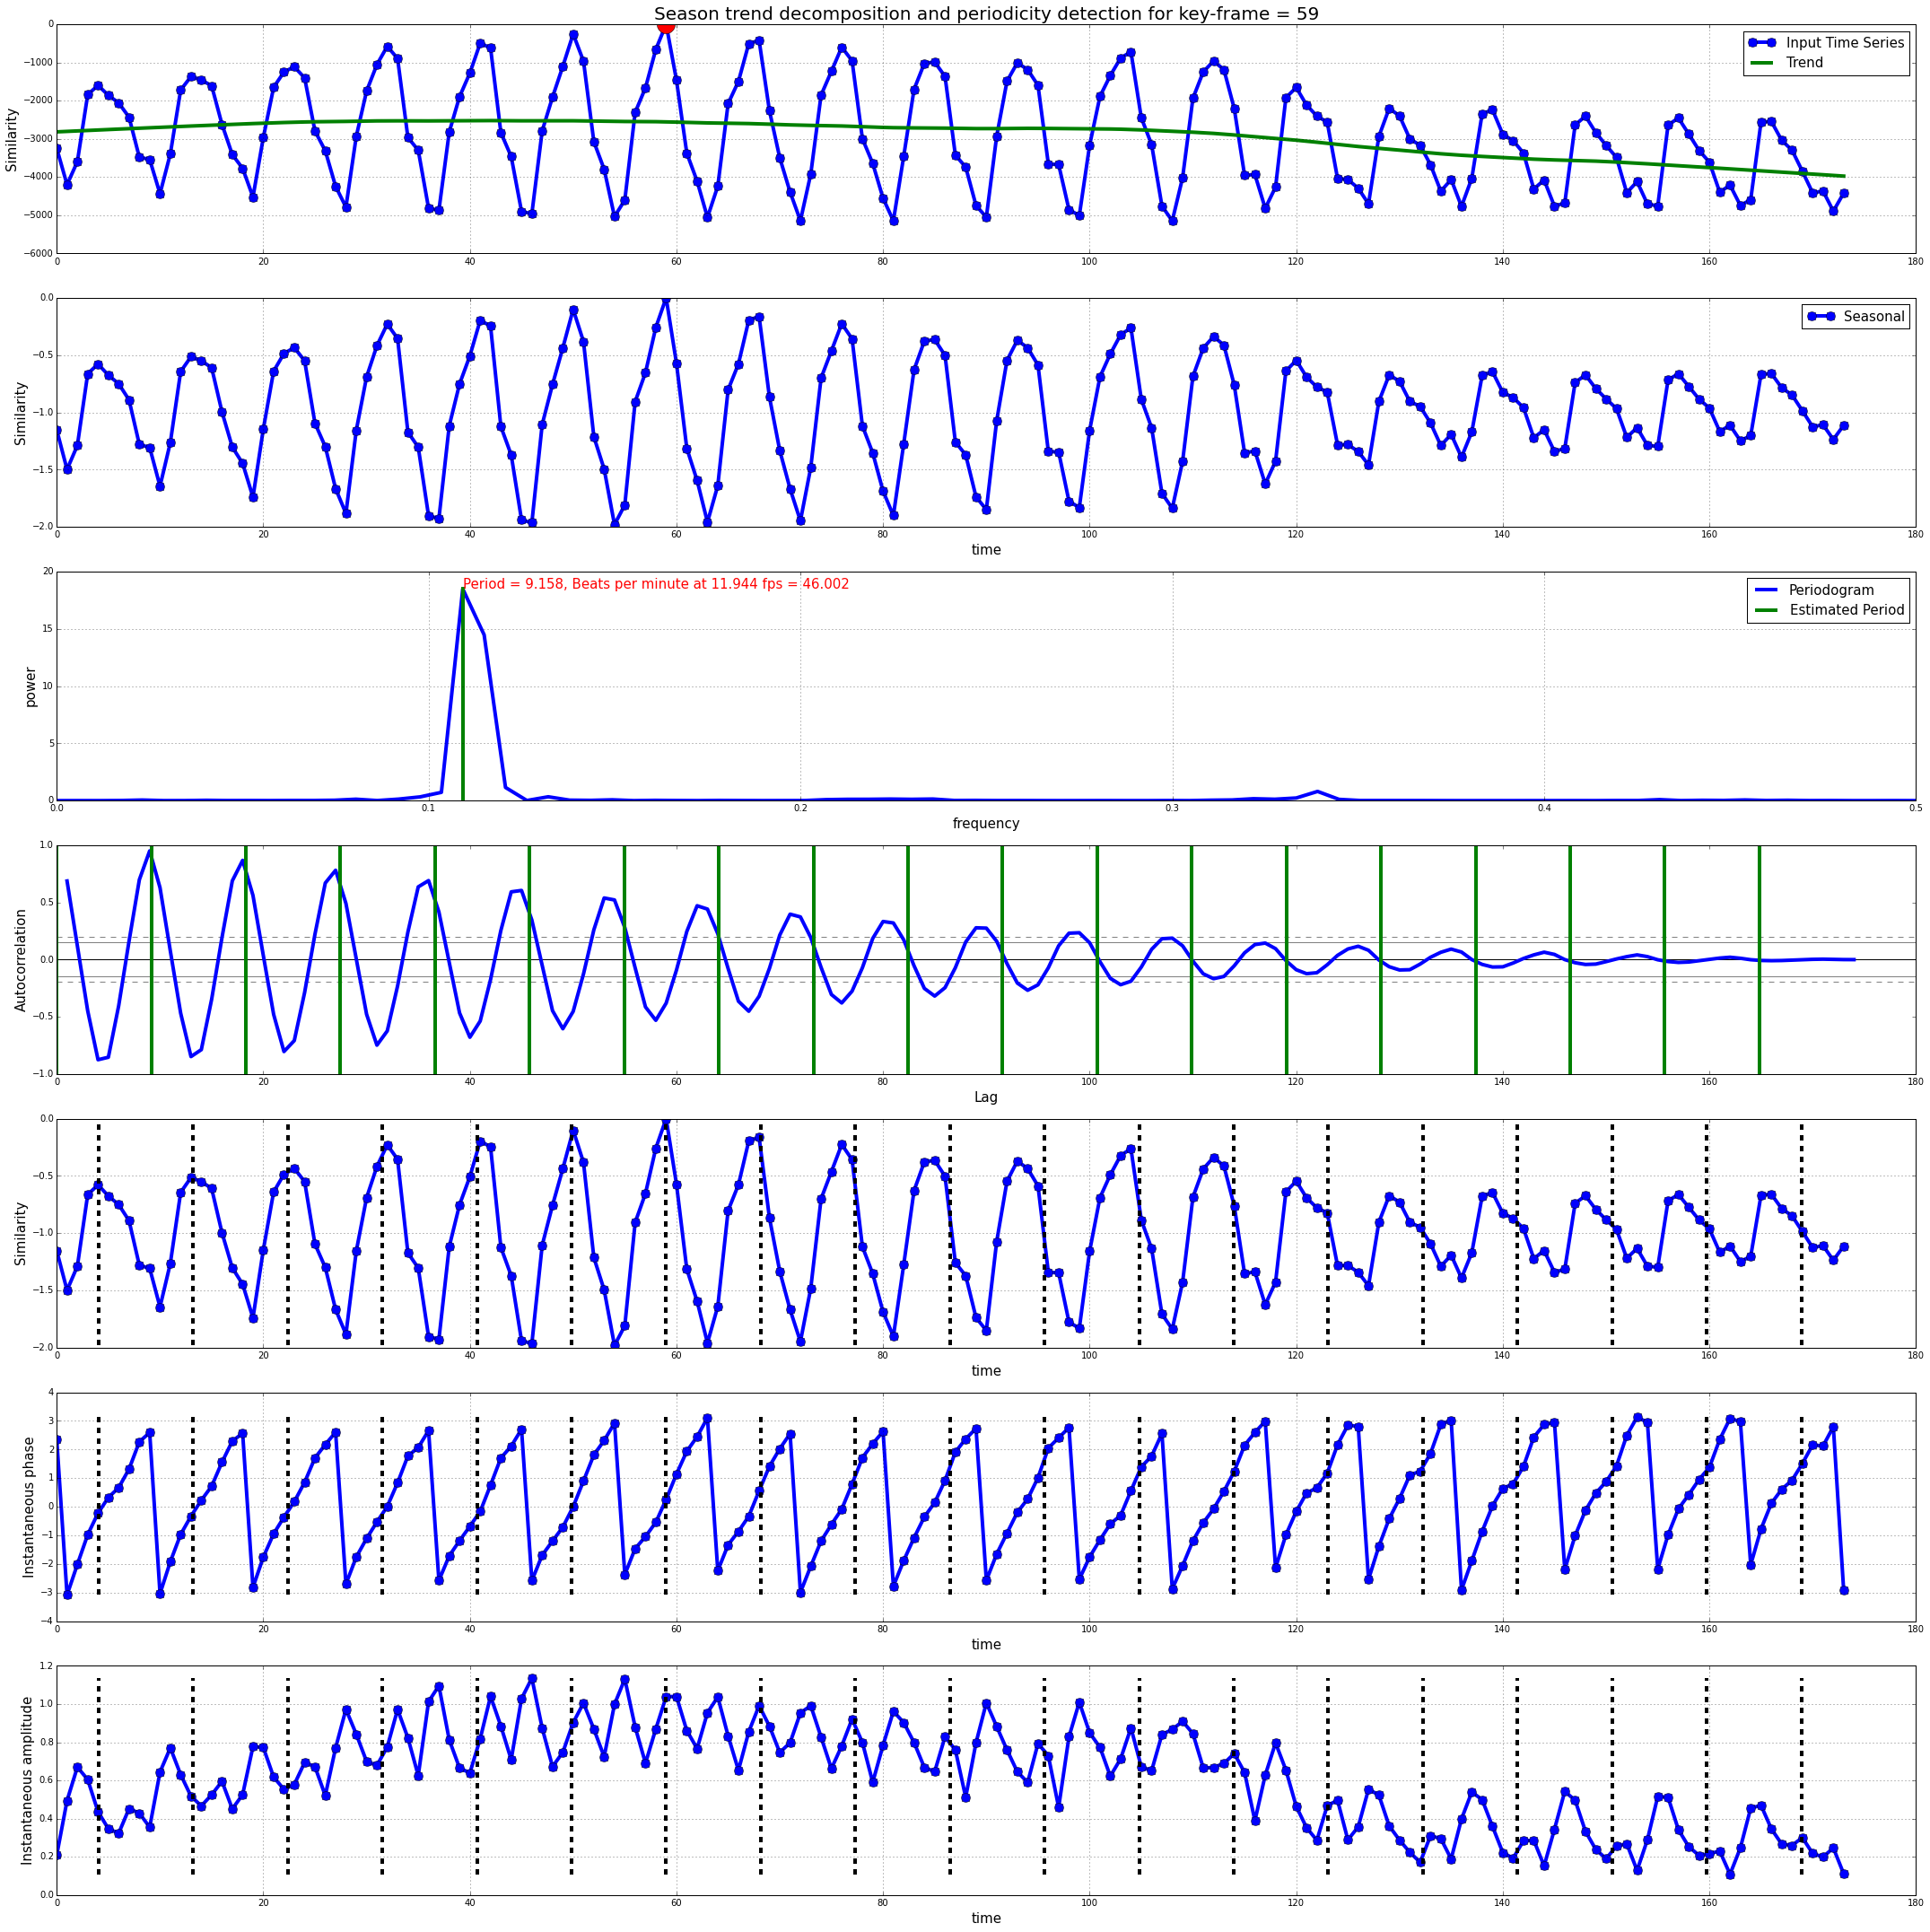

In [29]:
#
# plot the whole similarity landscape along with its trend and seasonal parts
#
fig, ax = plt.subplots(1, 3)

ax[0].imshow(simMat)
ax[0].set_title('Similarity - raw')
SaveImageToDisk(simMat, resultsDir, 'simMat')

ax[1].imshow(simMat_Trend)
ax[1].set_title('Similarity - trend')
SaveImageToDisk(simMat_Trend, resultsDir, 'simMat_Trend')

ax[2].imshow(simMat_Seasonal)
ax[2].set_title('Similarity - seasonal')
SaveImageToDisk(simMat_Seasonal, resultsDir, 'simMat_Seasonal')

#
# Plot frame entropy
#
plt.figure()
plt.plot(spectralEntropy, linewidth=4)
plt.plot(fid_best, spectralEntropy[fid_best], 'o', markersize=20, label='best frame')
plt.xlabel('time', fontsize=labelsize)
plt.ylabel('entropy', fontsize=labelsize)
plt.title('Periodogram entropy of the seasonal part', fontsize=titlesize)
plt.legend(fontsize=labelsize)

#
# Plot time series decomposition
#
fig, ax = plt.subplots(7, 1, figsize=(30, 30))
ax[0].set_title('Season trend decomposition and periodicity detection for key-frame = %d' % fid_best, 
                fontsize=titlesize)

ax[0].plot(ts, '-o', markersize = 10, linewidth=4, label='Input Time Series')
ax[0].plot(ts_trend, linewidth=4, label='Trend')
ax[0].plot(fid_best, ts[fid_best], 'o', markersize=20)
ax[0].legend(fontsize=labelsize)
ax[0].set_ylabel('Similarity', fontsize=labelsize)

ax[1].plot(ts_seasonal, '-o', markersize = 10, linewidth=4, label='Seasonal')
ax[1].set_xlabel('time', fontsize=labelsize)
ax[1].set_ylabel('Similarity', fontsize=labelsize)
ax[1].legend(fontsize=labelsize)

#
# Plot periodogram and estimated period
#
# show period on periodogram
freq, power = scipy.signal.periodogram(ts_seasonal)
beatsPerMinute = algo.period_ * 60.0 / framesPerSecDownsmp
print "beats per minute at %f fps = %f" % (framesPerSecDownsmp, beatsPerMinute)
maxPowerLoc = np.argmax(power)

ax[2].plot(freq, power, linewidth=4, label='Periodogram')
ax[2].plot([freq[maxPowerLoc], freq[maxPowerLoc]], 
           [0, power[maxPowerLoc]], 'g', linewidth=4, label='Estimated Period')
ax[2].text(freq[maxPowerLoc], power[maxPowerLoc], 
           'Period = %.3f, Beats per minute at %.3f fps = %.3f' % (period, framesPerSecDownsmp, beatsPerMinute), 
            fontsize=labelsize, color='r')
ax[2].set_xlabel('frequency', fontsize=labelsize)
ax[2].set_ylabel('power', fontsize=labelsize)
ax[2].legend(fontsize=labelsize)

# show period on the autocorrelation plot
pdplot.autocorrelation_plot(ts_seasonal, ax = ax[3], linewidth=4)
#sm.graphics.tsa.plot_acf(ts_seasonal, ax = ax[1], linewidth=4, fft=True, use_vlines=False, linestyle='-')
xvals = np.arange(0, ts_seasonal.size, period)
for x in xvals:
    ax[3].plot([x, x], [-1, 1], 'g', linewidth=4)
ax[3].yaxis.label.set_size(labelsize)
ax[3].xaxis.label.set_size(labelsize)

# show period on seasonal part and its instaneous phase
ax[4].plot(ts_seasonal, '-o', markersize = 10, linewidth=4)
ax[4].legend(fontsize=labelsize)
ax[4].set_xlabel('time', fontsize=labelsize)
ax[4].set_ylabel('Similarity', fontsize=labelsize)

ax[5].plot(ts_instaphase, '-o', markersize = 10, linewidth=4)
ax[5].set_xlabel('time', fontsize=labelsize)
ax[5].set_ylabel('Instantaneous phase', fontsize=labelsize)

ax[6].plot(ts_instaamp, '-o', markersize = 10, linewidth=4)
ax[6].set_xlabel('time', fontsize=labelsize)
ax[6].set_ylabel('Instantaneous amplitude', fontsize=labelsize)

seaspeakloc = np.argmax(ts_seasonal)
xvals = np.hstack( (np.arange(seaspeakloc, 0, -period), np.arange(seaspeakloc, ts_seasonal.size, period)) )
for x in xvals:    
    ax[4].plot([x, x], [ts_seasonal.min(), ts_seasonal.max()], '--k', linewidth=4)
    ax[5].plot([x, x], [ts_instaphase.min(), ts_instaphase.max()], '--k', linewidth=4)
    ax[6].plot([x, x], [ts_instaamp.min(), ts_instaamp.max()], '--k', linewidth=4)

fig.tight_layout()

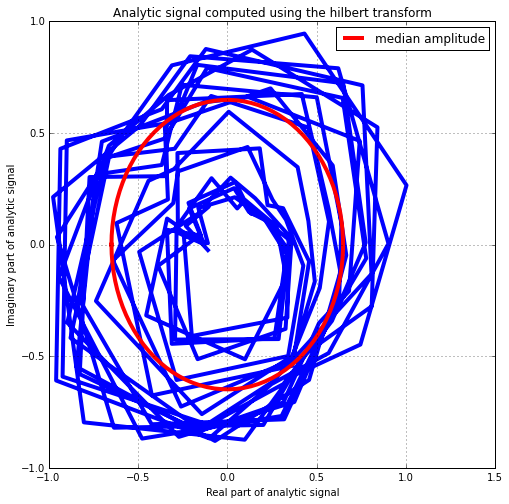

In [30]:
# show analytic signal
plt.figure(figsize=(8,8))
plt.plot(np.real(ts_analytic), np.imag(ts_analytic), linewidth=4)

xvals = np.linspace(-np.pi, np.pi, 100)
medianAmp = np.median(np.abs(ts_analytic))
plt.plot(medianAmp * np.cos(xvals), medianAmp * np.sin(xvals), 'r-', 
         linewidth=4, label='median amplitude')

plt.title('Analytic signal computed using the hilbert transform')
plt.xlabel('Real part of analytic signal')
plt.ylabel('Imaginary part of analytic signal')
plt.legend()

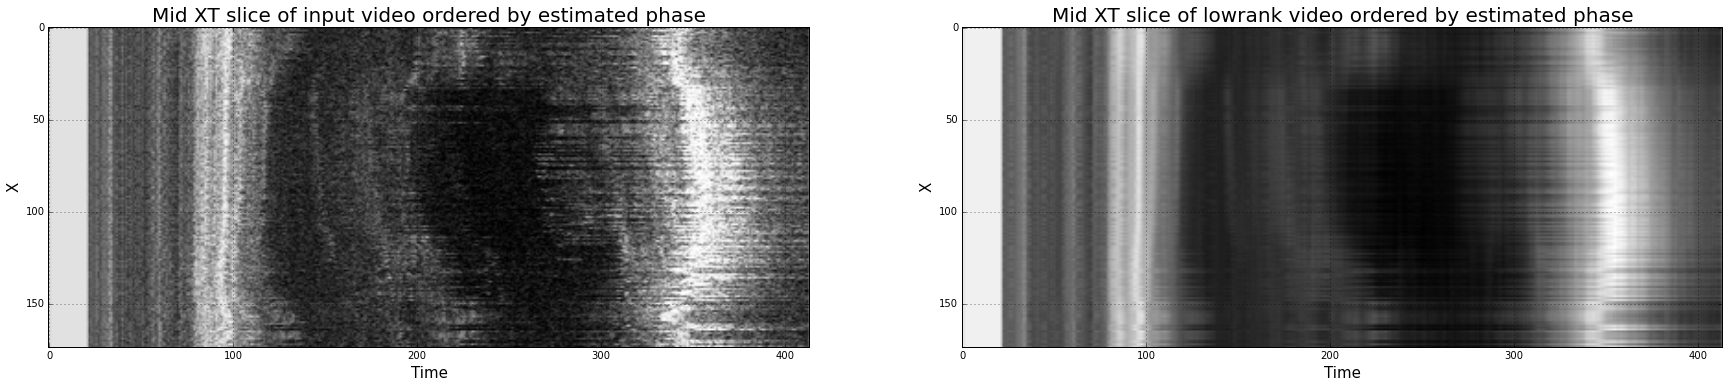

In [31]:
# order frames by phase
phaseord_est = np.argsort( ts_instaphase )
imInput_phaseord_est = imInput[:,:,phaseord_est]
imLowrank_phaseord_est = imLowRank[:,:,phaseord_est]

# show mid xz slice
plt.figure(figsize=(30, 10))

plt.subplot(121)
plt.imshow(imInput_phaseord_est[:, imInput_phaseord_est.shape[1]/2, :].T)
plt.title('Mid XT slice of input video ordered by estimated phase', fontsize=titlesize)
plt.xlabel('Time', fontsize=labelsize)
plt.ylabel('X', fontsize=labelsize)

plt.subplot(122)
plt.imshow(imLowrank_phaseord_est[:, imLowrank_phaseord_est.shape[1]/2, :].T)
plt.title('Mid XT slice of lowrank video ordered by estimated phase', fontsize=titlesize)
plt.xlabel('Time', fontsize=labelsize)
plt.ylabel('X', fontsize=labelsize)

In [245]:
# show video
cvShowVideo([normalizeArray(imInput_phaseord_est), normalizeArray(imLowrank_phaseord_est)],
            ['Input Video ordered by phase', 'Lowrank Video ordered by phase'], resizeAmount=resizeAmount)

In [30]:
writeVideoToFile(normalizeArray(imInput_phaseord_est), 
                 os.path.join(resultsDir, '%s.PhaseOrderedInput.avi' % resultFilePrefix), 
                 codec='DIVX', fps=12)

writeVideoToFile(normalizeArray(imLowrank_phaseord_est), 
                 os.path.join(resultsDir, '%s.PhaseOrderedLowrank.avi' % resultFilePrefix), 
                 codec='DIVX', fps=12)

True
Writing video ./VibratingCircle/VibratingCircle.PhaseOrderedInput.avi took 0.00449514389038 seconds
True
Writing video ./VibratingCircle/VibratingCircle.PhaseOrderedLowrank.avi took 0.00340008735657 seconds


### Try optical flow

In [34]:
def draw_flow(img, flow, step=16):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (x2, y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

def draw_hsv(flow):
    h, w = flow.shape[:2]
    fx, fy = flow[:,:,0], flow[:,:,1]
    ang = np.arctan2(fy, fx) + np.pi
    v = np.sqrt(fx*fx+fy*fy)
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[...,0] = ang*(180/np.pi/2)
    hsv[...,1] = 255
    hsv[...,2] = np.minimum(v*4, 255)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr

def warp_flow(img, flow):
    h, w = flow.shape[:2]
    flow = -flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
    return res

show_hsv = False
show_glitch = False
blnLoop = True
numFrames = imInput.shape[2]
winsize = np.max(np.ceil(0.05 * np.array(imInput.shape[:2]))).astype('int')

i = 0

while True:

    if i < 1:        
        i = i + 1
        continue

    imPrevFrame = imInput[:, :, i-1]
    imCurFrame = imInput[:, :, i]

    flow = cv2.calcOpticalFlowFarneback(imPrevFrame, imCurFrame, 0.5, 3, winsize, 3, 7, 1.5, 0)

    #cv2.imshow('flow', )
    cvShowColorImage(draw_flow(imCurFrame, flow), 'flow', '%d/%d' % (i, numFrames), resizeAmount=resizeAmount )

    if show_hsv:
        cv2.imshow('flow HSV', draw_hsv(flow))
    if show_glitch:
        imCurFrameEst = warp_flow(imPrevFrame.copy(), flow)
        cvShowImage(imCurFrameEst, 'warped',
                    '%d/%d' % (i, numFrames), resizeAmount=resizeAmount)
        
        cvShowImage(np.abs(imCurFrame-imCurFrameEst), 'diff',
                    '%d/%d' % (i, numFrames), resizeAmount=resizeAmount)
        

    # look for "esc" key
    k = cv2.waitKey(30) & 0xff

    if k == 27:   # escape
        break
    elif k == ord('1'):
        show_hsv = not show_hsv
        print 'HSV flow visualization is', ['off', 'on'][show_hsv]
    elif k == ord('2'):
        show_glitch = not show_glitch
        print 'glitch is', ['off', 'on'][show_glitch]
        
    if blnLoop:
        
        if k == ord(' '):  # space
            blnLoop = False
        else:
            i = (i + 1) % numFrames
            
    else:
        
        if k == ord(' '): # space                
            blnLoop = True                
        elif k == 81: # left arrow                
            i = (i - 1) % numFrames                
        elif k == 83: # right arrow                
            i = (i + 1) % numFrames              
        
cv2.destroyAllWindows()

glitch is on


## Step-4: Generate high-resolution video of one period using instantaneous phase of seasonal part 

In [40]:
# set upsampling amount
upsamplePerioidFactor = 8 #timeDownsamplingFrameStep
sigmaGKRFactor = 2
valve_mmode_x = 300 / resizeAmount
valve_mmode_yrange = np.array([200, 361]) / resizeAmount

# generate video of requested resolution using estimated phase
numOutFrames = np.uint( upsamplePerioidFactor * period + 0.5 )        

imOurOnePeriodMagVideo = algo.generateSinglePeriodVideo(numOutFrames, sigmaGKRFactor=sigmaGKRFactor, imInput=imInput)

SaveImageToDisk(imOurOnePeriodMagVideo[:,imOurOnePeriodMagVideo.shape[1]/2,:], 
                resultsDir, 'imHeartSuperRes_%d' % upsamplePerioidFactor)
#
# show mips
#

# display MIP of generated video
plt.figure(figsize=(30,20))

plt.subplot(231)
plt.imshow(imOurOnePeriodMagVideo.max(2))
plt.gca().autoscale(False)
plt.plot([valve_mmode_x, valve_mmode_x], valve_mmode_yrange, 'r', linewidth=linewidth)
plt.title('Time MIP of our one-period * %d video with selected m-mode line' % upsamplePerioidFactor)   

# display MIP of groundtruth
plt.subplot(232)
plt.imshow(imInput_highres_prenoise.max(2))
plt.title('Time MIP of high-resolution groundtruth without noise')        

plt.subplot(233)
plt.imshow(imInput_highres.max(2))
plt.title('Time MIP of high-resolution groundtruth with noise')

# display mid XT slice of generated video
plt.figure()

plt.imshow(imOurOnePeriodMagVideo[:,imOurOnePeriodMagVideo.shape[1]/2,:].T)
plt.title('Mid XT slice of generated video')   

# show selected m-mode image of generated one-period video
plt.figure()
plt.imshow(imOurOnePeriodMagVideo[valve_mmode_yrange[0]:valve_mmode_yrange[1], valve_mmode_x, :].T)
plt.xlabel('Depth', fontsize=labelsize)
plt.ylabel('Time', fontsize=labelsize)
plt.title('M-mode image of magnified one-period video')

SaveImageToDisk(imOurOnePeriodMagVideo[valve_mmode_yrange[0]:valve_mmode_yrange[1], valve_mmode_x, :], 
                resultsDir, 'imHeartSuperRes_ValveMMode_%d' % upsamplePerioidFactor)

AttributeError: 'USGatingAndSuperResolution' object has no attribute 'generateVideo'

In [36]:
cvShowVideo([normalizeArray(imInput), normalizeArray(imOurOnePeriodMagVideo)],
            ['Original Video', 'Synthesized One Period Video'], resizeAmount=resizeAmount)

In [47]:
writeVideoToFile( normalizeArray(imOurOnePeriodMagVideo) * 255, 
                 os.path.join(resultsDir, '%s.OurOnePeriodx%d.avi' % (resultFilePrefix, upsamplePerioidFactor)), 
                 codec='DIVX', fps=framesPerSec)

True
Writing video /home/cdeepakroy/work/gdrive_kitware/LowCostUltrasound/results/videos/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151027/Heart_20150220_151027.OurOnePeriodx8.avi took 0.150384902954 seconds


# Validation

## Generate groundtruth by manually cropping a sub-video of one-period length

Look at the instantaneous phase and seasonal part of the frame-to-frame similarity time series and adjust the min/max frame sliders which will then be used to crop out the corresponding part of the video from input high-resolution video

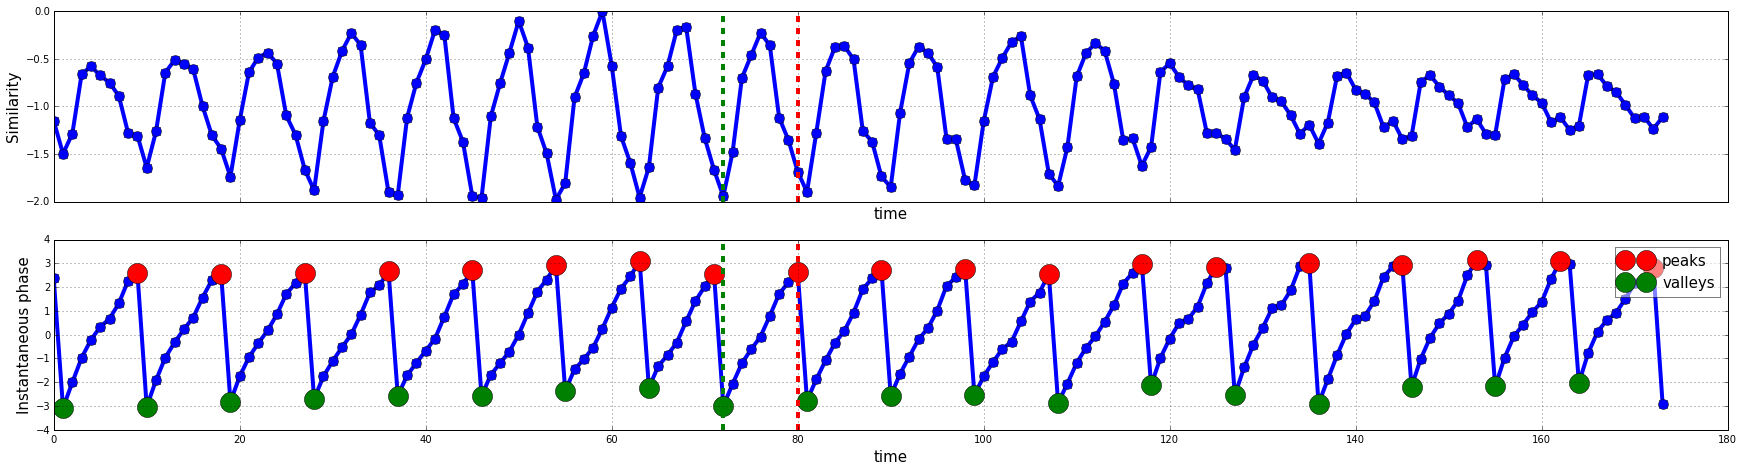

In [48]:
# create min-max frame selector widgets
nf = ts_instaphase.size
minFrameWidget = widgets.IntSliderWidget(min = 0, max = nf, step = 1)
maxFrameWidget = widgets.IntSliderWidget(min = 0, max = nf, step = 1)

# find good initial values for min-max frame
vloc = detect_peaks(ts_instaphase, mph = -np.pi/4, mpd=period * 0.75, valley=True, show=False)
ploc = detect_peaks(ts_instaphase, mph =  np.pi/4, mpd=period * 0.75, valley=False, show=False)

vloc_central = vloc[( (vloc > 0.25 * nf) & (vloc < 0.75 * nf) )]

#vloc_best_ind = np.argmin( np.abs( np.diff( ts_seasonal[vloc_central] ) ) )
vloc_best_ind = np.argmin(ts_instaphase[vloc_central])

minFrameWidget.value = vloc_central[vloc_best_ind]
maxFrameWidget.value = ploc[ploc > minFrameWidget.value + 0.8 * period][0]

# display seasonal part of similarity time series and its instantaneous phase
fig, ax = plt.subplots(2, 1, sharex=True)
plt.close(fig)

ax[0].plot(ts_seasonal, '-o', markersize = 10, linewidth=4)
ax[0].set_xlabel('time', fontsize=labelsize)
ax[0].set_ylabel('Similarity', fontsize=labelsize)
ax[0].legend(fontsize=labelsize, framealpha=0.5)

ax[1].plot(ts_instaphase, '-o', markersize = 10, linewidth=4)
ax[1].set_xlabel('time', fontsize=labelsize)
ax[1].set_ylabel('Instantaneous phase', fontsize=labelsize)
ax[1].plot(ploc, ts_instaphase[ploc], 'ro', markersize = 20, label='peaks')
ax[1].plot(vloc, ts_instaphase[vloc], 'go', markersize = 20, label='valleys')
ax[1].legend(fontsize=labelsize, framealpha=0.5)

# display initial min-max frames
minLine = []
maxLine = []

for aid in range(ax.size):

    minLine.append( ax[aid].plot([minFrameWidget.value, minFrameWidget.value],
                                 ax[aid].get_ylim(), 'g--', linewidth=4)[0] )
    maxLine.append( ax[aid].plot([maxFrameWidget.value, maxFrameWidget.value],
                                 ax[aid].get_ylim(), 'r--', linewidth=4)[0] )

# define and set event handler to show current min-max frames
def show_selected_min_max_frames(minFrame, maxFrame):
    
    # show min-max frames
    for aid in range(ax.size):

        minLine[aid].set_xdata([minFrame, minFrame])
        maxLine[aid].set_xdata([maxFrame, maxFrame])
        
    display(fig)
    
interactive(show_selected_min_max_frames, minFrame = minFrameWidget, maxFrame = maxFrameWidget)

Selected frame range of high-res video: [216, 240]
Image size of single period groundtruth (414, 525, 25)


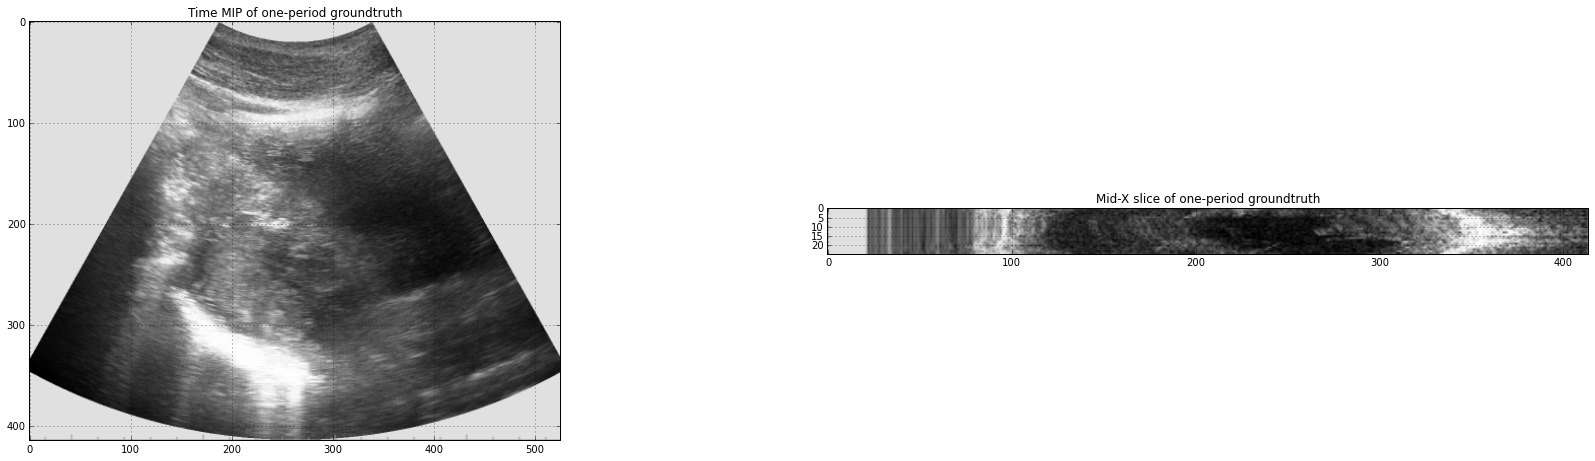

In [49]:
minFrameHighRes = minFrameWidget.value * timeDownsamplingFrameStep
maxFrameHighRes = maxFrameWidget.value * timeDownsamplingFrameStep
print 'Selected frame range of high-res video: [%d, %d]' % (minFrameHighRes, maxFrameHighRes)

imOnePeriod_Groundtruth = imInput_highres_prenoise[:, :, minFrameHighRes:maxFrameHighRes+1]
print 'Image size of single period groundtruth', imOnePeriod_Groundtruth.shape

# display cropped ground truth
fig, ax = plt.subplots(1, 2)

ax[0].imshow(imOnePeriod_Groundtruth.max(2))
ax[0].set_title('Time MIP of one-period groundtruth')    

ax[1].imshow(imOnePeriod_Groundtruth[:, imOnePeriod_Groundtruth.shape[1]/2, :].T)
ax[1].set_title('Mid-X slice of one-period groundtruth')    

In [139]:
cvShowVideo(normalizeArray(imOnePeriod_Groundtruth), 'One-Period Groundtruth', resizeAmount=resizeAmount)

In [50]:
writeVideoToFile(normalizeArray(imOnePeriod_Groundtruth) * 255, 
                 os.path.join(resultsDir, '%s.OnePeriod_Groundtruth.avi' % resultFilePrefix), 
                 codec='DIVX', fps=framesPerSec)

True
Writing video /home/cdeepakroy/work/gdrive_kitware/LowCostUltrasound/results/videos/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151027/Heart_20150220_151027.OnePeriod_Groundtruth.avi took 0.0831220149994 seconds


## Compare the results of our method with spline interpolation

In [55]:
numOutFrames = imOnePeriod_Groundtruth.shape[2]

# compute the result using spline interpolation
print '\nValidating the gated video generated using spline interpolation ... ', 

maxSplineOrder = 6

imOnePeriodVal_Spline = [None]*maxSplineOrder
sim_Spline = np.zeros((maxSplineOrder, 1))

for splineOrder in range(maxSplineOrder):
    
    imOnePeriodVal_Spline[splineOrder] = generateGatedVideoUsingSplineInterp(imInput, numOutFrames,
                                                                             minFrameWidget.value, 
                                                                             maxFrameWidget.value,
                                                                             splineOrder)
    
    sim_Spline[splineOrder] = ncorr(imOnePeriod_Groundtruth, imOnePeriodVal_Spline[splineOrder])
    
    # update progress
    print splineOrder,    

# compute result using our method
print '\nValidating the gated video generated using our method ... '

phaseRange = [(i + np.pi) / (2.0 * np.pi) 
              for i in ts_instaphase[ [minFrameWidget.value, maxFrameWidget.value] ] ]

imOnePeriodVal_Our = algo.generateSinglePeriodVideo(imOnePeriod_Groundtruth.shape[2], 
                                                    sigmaGKRFactor=2, phaseRange=phaseRange, imInput=imInput)  

sim_Our = ncorr(imOnePeriod_Groundtruth, imOnePeriodVal_Our)


Validating the gated video generated using spline interpolation ...  0 1 2 3 4 5 
Validating the gated video generated using our method ... 
sigmaGKR =  0.0717541627181
04% 08% 12% 16% 20% 24% 28% 32% 36% 40% 44% 48% 52% 56% 60% 64% 68% 72% 76% 80% 84% 88% 92% 96%


0 1 2 3 4 5

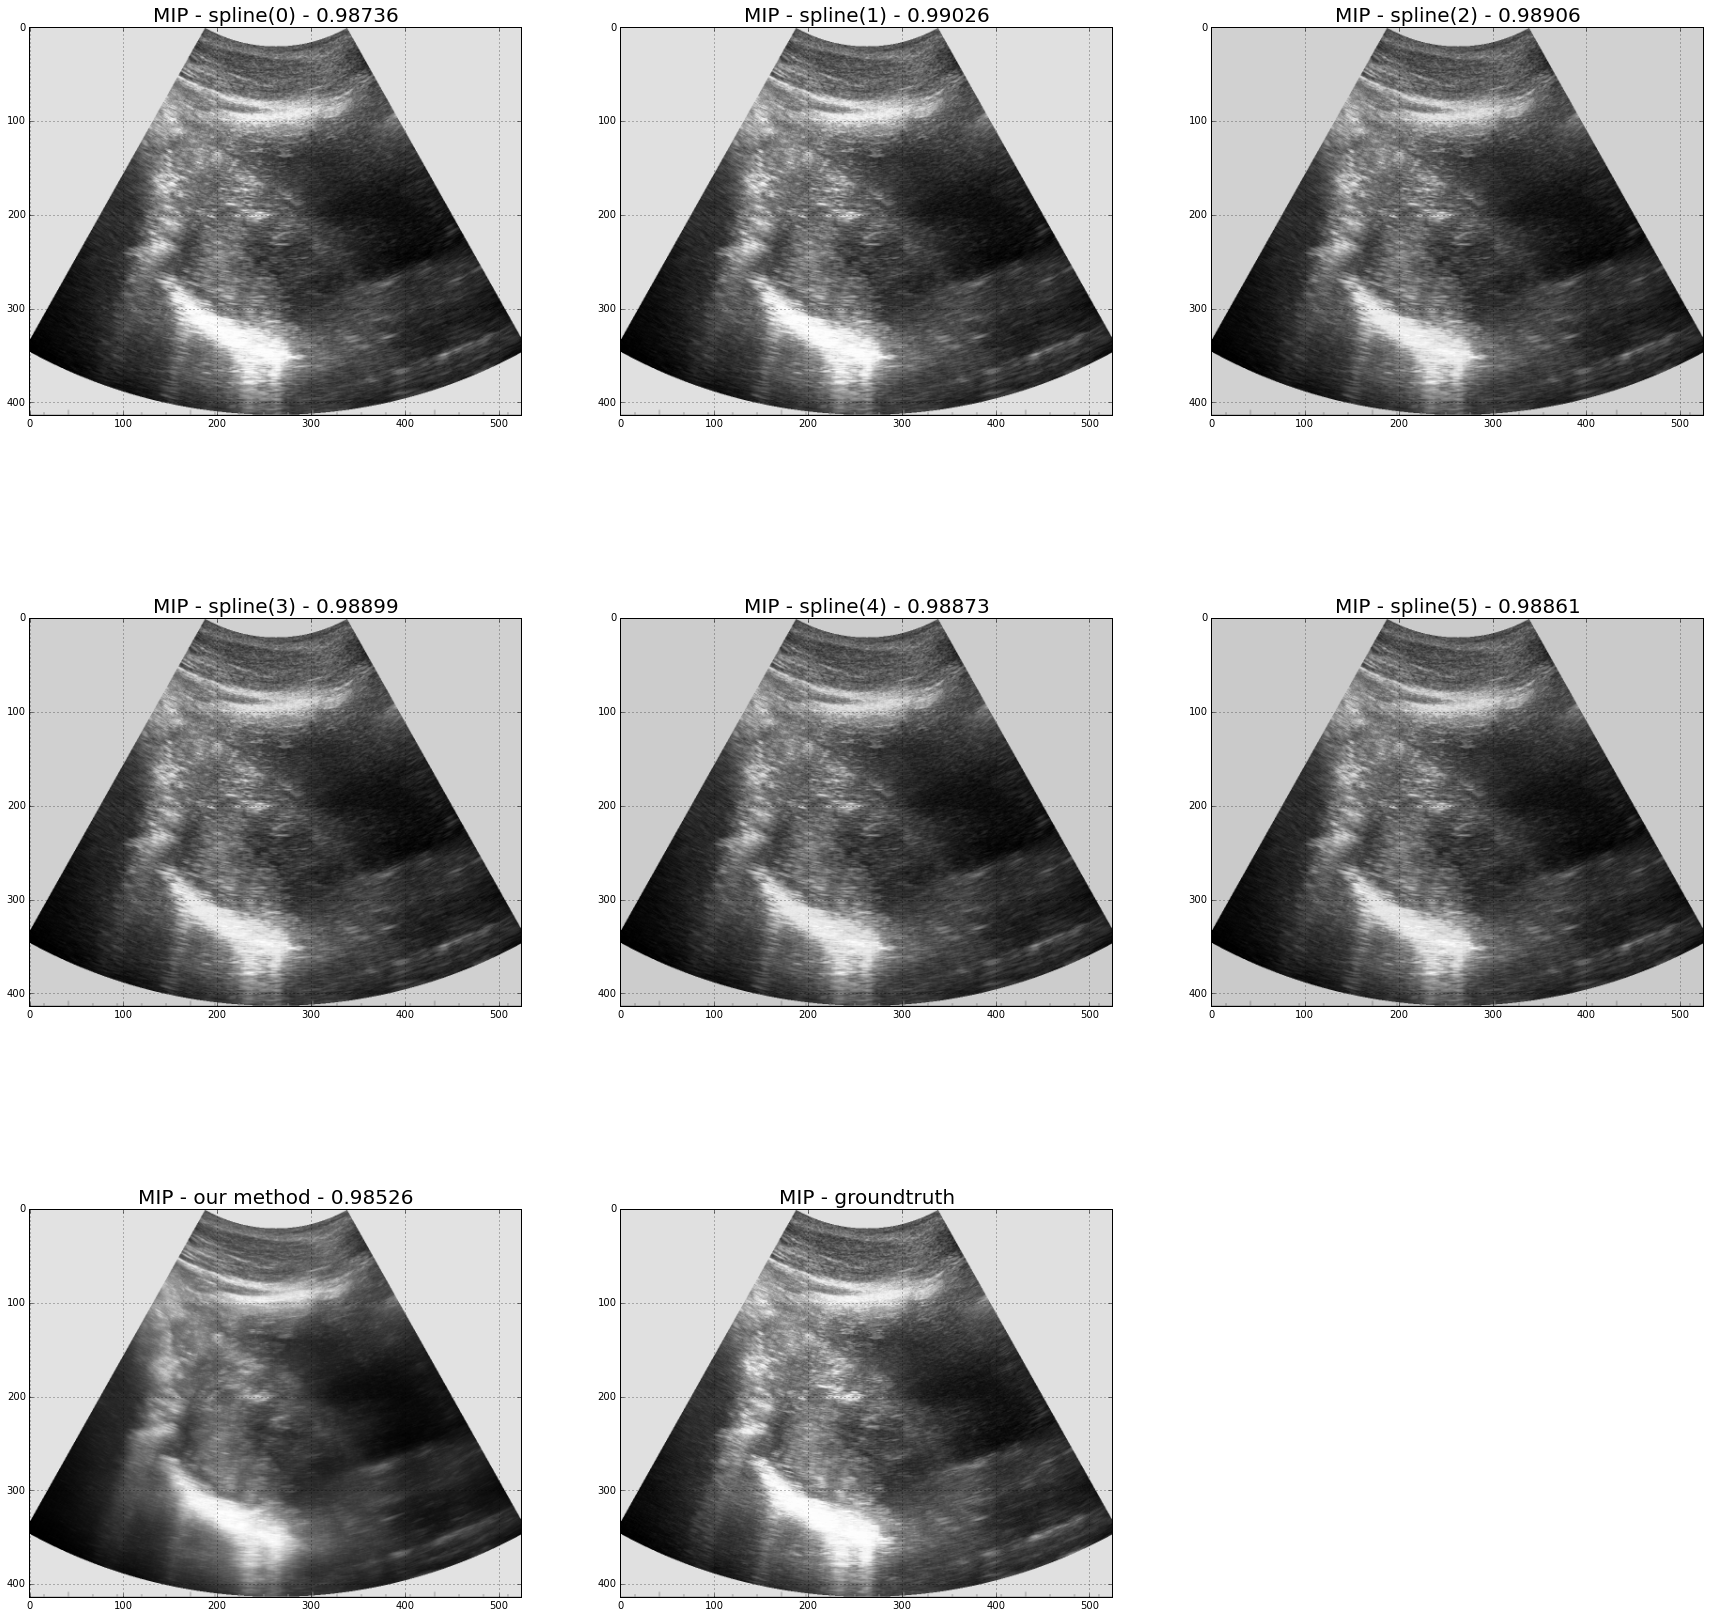

In [56]:
#
# show Time MIPs to check denoising 
#

# show result using spline interpolation
plt.figure(figsize=(30, 30))

for splineOrder in range(maxSplineOrder):
    
    # show MIP
    plt.subplot2grid((3, 3), (splineOrder/3, splineOrder%3))
    imshow(imOnePeriodVal_Spline[splineOrder].max(2))
    plt.title('MIP - spline(%d) - %.5f' % (splineOrder, sim_Spline[splineOrder]), 
              fontsize=titlesize)   

    # update progress
    print splineOrder,    

# show result using our method with RBF
plt.subplot2grid((3, 3), (2, 0))
plt.imshow(imOnePeriodVal_Our.max(2))
plt.title('MIP - our method - %.5f' % sim_Our, fontsize=titlesize)

# show groundtruth
plt.subplot2grid((3, 3), (2, 1))
plt.imshow(imOnePeriod_Groundtruth.max(2))
plt.title('MIP - groundtruth', fontsize=titlesize)

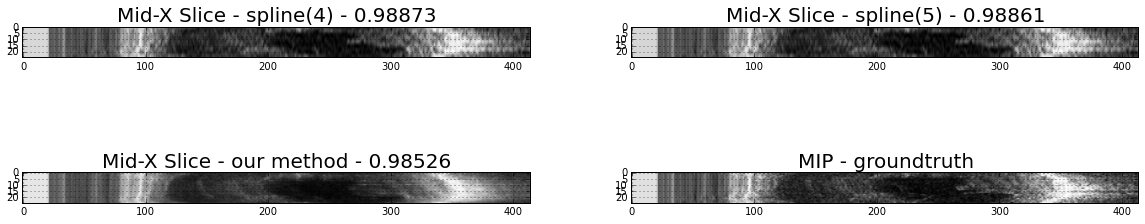

In [57]:
#
# show Mid XT slices 
#

# show result using spline interpolation
plt.figure(figsize=(20, 5))

for splineOrder in range(maxSplineOrder):
    
    # show MIP
    plt.subplot2grid((4, 2), (splineOrder/4, splineOrder%4))
    imshow(imOnePeriodVal_Spline[splineOrder][:, imOnePeriodVal_Spline[splineOrder].shape[1]/2, :].T)
    plt.title('Mid-X Slice - spline(%d) - %.5f' % (splineOrder, sim_Spline[splineOrder]), 
              fontsize=titlesize)   

# compute result using our method with RBF
sim_Our = ncorr(imOnePeriod_Groundtruth, imOnePeriodVal_Our)

plt.subplot2grid((4, 2), (3, 0))
plt.imshow(imOnePeriodVal_Our[:, imOnePeriodVal_Our.shape[1]/2, :].T)
plt.title('Mid-X Slice - our method - %.5f' % sim_Our, fontsize=titlesize)

# show groundtruth
plt.subplot2grid((4, 2), (3, 1))
plt.imshow(imOnePeriod_Groundtruth[:, imOnePeriod_Groundtruth.shape[1]/2, :].T)
plt.title('MIP - groundtruth', fontsize=titlesize)

In [187]:
# show all results together
vids = [normalizeArray(imOnePeriod_Groundtruth)]
vidlabels = ['Groundtruth']

vids.append(normalizeArray(imOnePeriodVal_Our))
vidlabels.append('Our Method') 

for splineOrder in range(maxSplineOrder):
    
    vids.append(normalizeArray(imOnePeriodVal_Spline[splineOrder]))
    vidlabels.append('Spline of order %d' % splineOrder) 

cvShowVideo(vids, vidlabels, resizeAmount=resizeAmount)

In [58]:
# write our result
writeVideoToFile(normalizeArray(imOnePeriodVal_Our) * 255, 
                 os.path.join(resultsDir, '%s.OnePeriod_Our.avi' % resultFilePrefix), 
                 codec='DIVX', fps=framesPerSec)

True
Writing video /home/cdeepakroy/work/gdrive_kitware/LowCostUltrasound/results/videos/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151027/Heart_20150220_151027.OnePeriod_Our.avi took 0.0701570510864 seconds


In [59]:
# write spline result
for splineOrder in range(maxSplineOrder):
    
    print splineOrder
    writeVideoToFile(normalizeArray(imOnePeriodVal_Spline[splineOrder]) * 255, 
                     os.path.join(resultsDir, 
                                  '%s.OnePeriod_Spline-ord-%d.avi' % (resultFilePrefix, splineOrder)), 
                     codec='DIVX', fps=framesPerSec)


0
True
Writing video /home/cdeepakroy/work/gdrive_kitware/LowCostUltrasound/results/videos/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151027/Heart_20150220_151027.OnePeriod_Spline-ord-0.avi took 0.0637760162354 seconds
1
True
Writing video /home/cdeepakroy/work/gdrive_kitware/LowCostUltrasound/results/videos/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151027/Heart_20150220_151027.OnePeriod_Spline-ord-1.avi took 0.0734210014343 seconds
2
True
Writing video /home/cdeepakroy/work/gdrive_kitware/LowCostUltrasound/results/videos/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151027/Heart_20150220_151027.OnePeriod_Spline-ord-2.avi took 0.0710229873657 seconds
3
True
Writing video /home/cdeepakroy/work/gdrive_kitware/LowCostUltrasound/results/videos/SHeart2015-02-20-HRes-HFPS/Heart_20150220_151027/Heart_20150220_151027.OnePeriod_Spline-ord-3.avi took 0.0717041492462 seconds
4
True
Writing video /home/cdeepakroy/work/gdrive_kitware/LowCostUltrasound/results/videos/SHeart2015-02-20-HRes-HFPS/Heart_2015